<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [27]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import load_model
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from keras.utils import plot_model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Input

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 20.0MB/s]


In [4]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [5]:
in_encoder_txt = []
in_decoder_txt = []
out_decoder_txt = []
max_len = 40

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'[\W_]+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        in_encoder_txt.append(chat_in)
        in_decoder_txt.append('sostok ' + chat_out)
        out_decoder_txt.append(chat_out + ' eostok')

print("Number of lines:", len(in_encoder_txt))

Number of lines: 8630


In [ ]:
in_encoder_txt[1], in_decoder_txt[1], out_decoder_txt[1]

('hi how are you ', 'sostok not bad and you ', 'not bad and you  eostok')

In [6]:
in_encoder_words = [word for sentence in in_encoder_txt for word in sentence.split()]
in_encoder_unique_words = set(in_encoder_words)
print("Number of words in encoder input:", len(in_encoder_unique_words))

in_decoder_words = [word for sentence in in_decoder_txt for word in sentence.split()]
in_decoder_unique_words = set(in_decoder_words)
print("Number of words in decoder input:", len(in_decoder_unique_words))

out_decoder_words = [word for sentence in out_decoder_txt for word in sentence.split()]
out_decoder_unique_words = set(out_decoder_words)
print("Number of words in decoder output:", len(out_decoder_unique_words))


Number of words in encoder input: 2503
Number of words in decoder input: 2494
Number of words in decoder output: 2494


In [7]:
# Verify that both sets are the same except for <sos> and <eos>
assert len(in_decoder_unique_words - out_decoder_unique_words) == 1
assert len(out_decoder_unique_words - in_decoder_unique_words) == 1

In [8]:
unique_words = in_encoder_unique_words.union(in_decoder_unique_words, out_decoder_unique_words)
print(f"Total number of words: {len(unique_words)}")

Total number of words: 2791


---

### **2. Preprocesamiento**
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

**Tokenize sentences**

In [9]:
MAX_VOCAB_SIZE = 8000

tok = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tok.fit_on_texts(in_encoder_txt + in_decoder_txt + out_decoder_txt)

in_encoder_seq = tok.texts_to_sequences(in_encoder_txt)
in_decoder_seq = tok.texts_to_sequences(in_decoder_txt)
out_decoder_seq = tok.texts_to_sequences(out_decoder_txt)

word2idx = tok.word_index
vocab_size = min(MAX_VOCAB_SIZE, len(word2idx))
print("Words in the vocabulary:", len(word2idx))

max_input_len = max(len(sen) for sen in in_encoder_seq)
print("Longest input sequence:", max_input_len)
max_input_len = max(len(sen) for sen in in_decoder_seq)
print("Longest output sequence:", max_input_len)

Words in the vocabulary: 2792
Longest input sequence: 12
Longest output sequence: 12


Vamos a observar si el tokenizador posee terminos diferentes a los encontrados anteriormente utilizando list comprehensions.

In [10]:
unique_words - set(word2idx.keys())

set()

In [11]:
set(word2idx.keys()) - unique_words

{'<OOV>'}

Utilizando "sostok" y "eostok" evitamos que el tokenizador elimine los caracteres especiales y genere una nueva clave de diccionario diferente a la seteada anteriormente (por ejemplo, si usaramos "\<sos\>", el toeknizador devolveria "sos"). El unico termino presente en el tokenizador, pero no en los textos es aquel correspondiente a las palabras desconocidas.

**Add padding**

Seleccionamos como padding maximo a la sequencia mas larga obtenida, en este caso 12. El padding lo incorporamos al principio para los inputs del encoder, y al final para los inputs y outputs del decoder.

In [12]:
max_seq_length = 12

print("Cantidad de rows del dataset:", len(in_encoder_seq))

in_encoder_pad = pad_sequences(in_encoder_seq, maxlen=max_seq_length)
print("encoder_input_sequences shape:", in_encoder_pad.shape)

in_decoder_pad = pad_sequences(in_decoder_seq, maxlen=max_seq_length, padding='post')
print("decoder_input_sequences shape:", in_decoder_pad.shape)

out_decoder_pad = pad_sequences(out_decoder_seq, maxlen=max_seq_length, padding='post')
print("decoder_input_sequences shape:", out_decoder_pad.shape)

Cantidad de rows del dataset: 8630
encoder_input_sequences shape: (8630, 12)
decoder_input_sequences shape: (8630, 12)
decoder_input_sequences shape: (8630, 12)


**Encode target**

La ultima capa del modelo (softmax) requiere que los valores de salida del decoder esten en formato one-hot. Utilizamo

In [13]:
from keras.utils import to_categorical

out_decoder_ohot = to_categorical(out_decoder_pad, num_classes=vocab_size)

In [14]:
out_decoder_ohot.shape

(8630, 12, 2792)

---

### **3. Embeddings**

In [15]:
# Descargar los embeddings desde un google drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque de código
# if os.access('gloveembedding.pkl', os.F_OK) is False:
#     url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
#     output = 'gloveembedding.pkl'
#     gdown.download(url, output, quiet=False)
# else:
#     print("Los embeddings gloveembedding.pkl ya están descargados")

if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Downloading...
From (original): https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa
From (redirected): https://drive.google.com/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&confirm=t&uuid=47bead96-7080-4b76-b910-c9aa8562fea6
To: /content/fasttext.pkl
100%|██████████| 2.88G/2.88G [00:37<00:00, 77.5MB/s]


In [ ]:
# En caso de que gdown de algún error de permisos intentar descargar los
# embeddings con curl:

# !curl -L -o 'gloveembedding.pkl' 'https://drive.google.com/u/0/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t'

In [16]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [17]:
# Get Fast Text embeddings
model_embeddings = FasttextEmbeddings()

In [18]:
# Get embeddings for words in our vocabulary only
print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

embedding_matrix = np.zeros((vocab_size + 1, embed_dim)) # + 1 for padding
for word, i in word2idx.items(): # word2idx defined with tokenizer
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


El unico token con embedding nulo es el correspondiente al padding.

In [19]:
embedding_matrix.shape

(2793, 300)

In [20]:
# Interestingly out of vocabulary token also has a valid embedding in FastText
model_embeddings.get_words_embeddings("<OOV>")[0][:10]

array([ 0.4184, -0.405 , -0.1197, -0.2751, -0.1055, -0.0549, -0.5094,
       -0.0115, -0.2128,  0.1568], dtype=float32)

---

### **4. Entrenamiento del modelo**

Los hiperparametros que vamos a tunear para realizar diferentes pruebas son la cantidad de neuronas en las capas LSTM, y la posibilidad de utilizar una capa bidireccional en el encoder (ya que el estado que pase al decoder va a tener informacion contextual mas rica).

**Define utils**

In [30]:
# Define inference function
idx2word = {v:k for k, v in word2idx.items()}

def give_response(input_txt, tok, max_input_len):
    input_seq = tok.texts_to_sequences([input_txt])[0]
    input_pad = pad_sequences([input_seq], maxlen=max_input_len)

    # Obtain initial encoder state
    state_value = encoder_model.predict(input_pad)

    # Initialize decoder with <sos> token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx['sostok']

    # Obtain <eos> token idx
    eos = word2idx['eostok']

    output_sentence = []
    for _ in range(10):
        # predict next element
        output_tokens, h, c = decoder_model.predict([target_seq] + state_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        # Convert idx to word
        if idx > 0:
            word = idx2word[idx]
            output_sentence.append(word)

        # Update state with last prediction
        state_value = [h, c]

        # Update decoder input sequence
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

**Model 1**

Comenzamos utilizando 128 neuronas en la capa LSTM, y no utilizamos bidireccional.

In [70]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate
from keras.optimizers import Nadam

n_units = 128

# ENCODER
# Input
encoder_inputs = Input(shape=(max_seq_length,), name="encoder_inputs")

# Embedding
encoder_embedding_layer = Embedding(
          input_dim=vocab_size + 1,  # vocabulary + padding
          output_dim=embed_dim,  # 300 for FastText
          weights=[embedding_matrix],  # includes padding and oov
          trainable=False,
          name="encoder_embeddings"
          )
encoder_inputs_embed = encoder_embedding_layer(encoder_inputs)

# LSTM
encoder_lstm_layer = LSTM(
    n_units,
    return_state=True,
    dropout=0.2,
    recurrent_dropout=0.2,
    name="encoder_LSTM"
    )
_, *encoder_state = encoder_lstm_layer(encoder_inputs_embed)

# DECODER
# Input
decoder_inputs = Input(shape=(max_seq_length,), name="decoder_inputs")

# Embedding
decoder_embedding_layer = Embedding(
          input_dim=vocab_size + 1,  # vocabulary + padding
          output_dim=embed_dim,  # 300 for FastText
          weights=[embedding_matrix],  # includes padding and oov
          trainable=False,
          name="decoder_embeddings"
          )
decoder_inputs_embed = decoder_embedding_layer(decoder_inputs)

# LSTM
decoder_lstm_layer = LSTM(
    n_units,
    return_sequences=True,
    return_state=True,
    dropout=0.2,
    recurrent_dropout=0.2,
    name="decoder_lstm"
    )
decoder_outputs, *_ = decoder_lstm_layer(decoder_inputs_embed, initial_state=encoder_state)

# Dense
decoder_dense_layer = Dense(
    vocab_size,
    activation='softmax',
    name="decoder_dense"
    )
decoder_outputs = decoder_dense_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

optimizer = Nadam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, 12)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, 12)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_embeddings        │ (None, 12, 300)        │        837,900 │ encoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embeddings        │ (None, 12, 300)        │        837,900 │ decoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_LSTM (LSTM)       │ [(None, 128), (None,   │        219,648 │ encoder_embeddings[0]… │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_lstm (LSTM)       │ [(None, 12, 128),      │        219,648 │ decoder_embeddings[0]… │
│                           │ (None, 128), (None,    │                │ encoder_LSTM[0][1],    │
│                           │ 128)]                  │                │ encoder_LSTM[0][2]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_dense (Dense)     │ (None, 12, 2792)       │        360,168 │ decoder_lstm[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,475,264 (9.44 MB)

 Trainable params: 799,464 (3.05 MB)

 Non-trainable params: 1,675,800 (6.39 MB)

    Model: "functional_9"
    ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
    ┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
    ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
    │ encoder_inputs            │ (None, 12)             │              0 │ -                      │
    │ (InputLayer)              │                        │                │                        │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ decoder_inputs            │ (None, 12)             │              0 │ -                      │
    │ (InputLayer)              │                        │                │                        │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ encoder_embeddings        │ (None, 12, 300)        │        837,900 │ encoder_inputs[0][0]   │
    │ (Embedding)               │                        │                │                        │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ decoder_embeddings        │ (None, 12, 300)        │        837,900 │ decoder_inputs[0][0]   │
    │ (Embedding)               │                        │                │                        │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ encoder_LSTM (LSTM)       │ [(None, 128), (None,   │        219,648 │ encoder_embeddings[0]… │
    │                           │ 128), (None, 128)]     │                │                        │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ decoder_lstm (LSTM)       │ [(None, 12, 128),      │        219,648 │ decoder_embeddings[0]… │
    │                           │ (None, 128), (None,    │                │ encoder_LSTM[0][1],    │
    │                           │ 128)]                  │                │ encoder_LSTM[0][2]     │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ decoder_dense (Dense)     │ (None, 12, 2792)       │        360,168 │ decoder_lstm[0][0]     │
    └───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘
    Total params: 2,475,264 (9.44 MB)
    Trainable params: 799,464 (3.05 MB)
    Non-trainable params: 1,675,800 (6.39 MB)

In [ ]:
# TRAIN model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

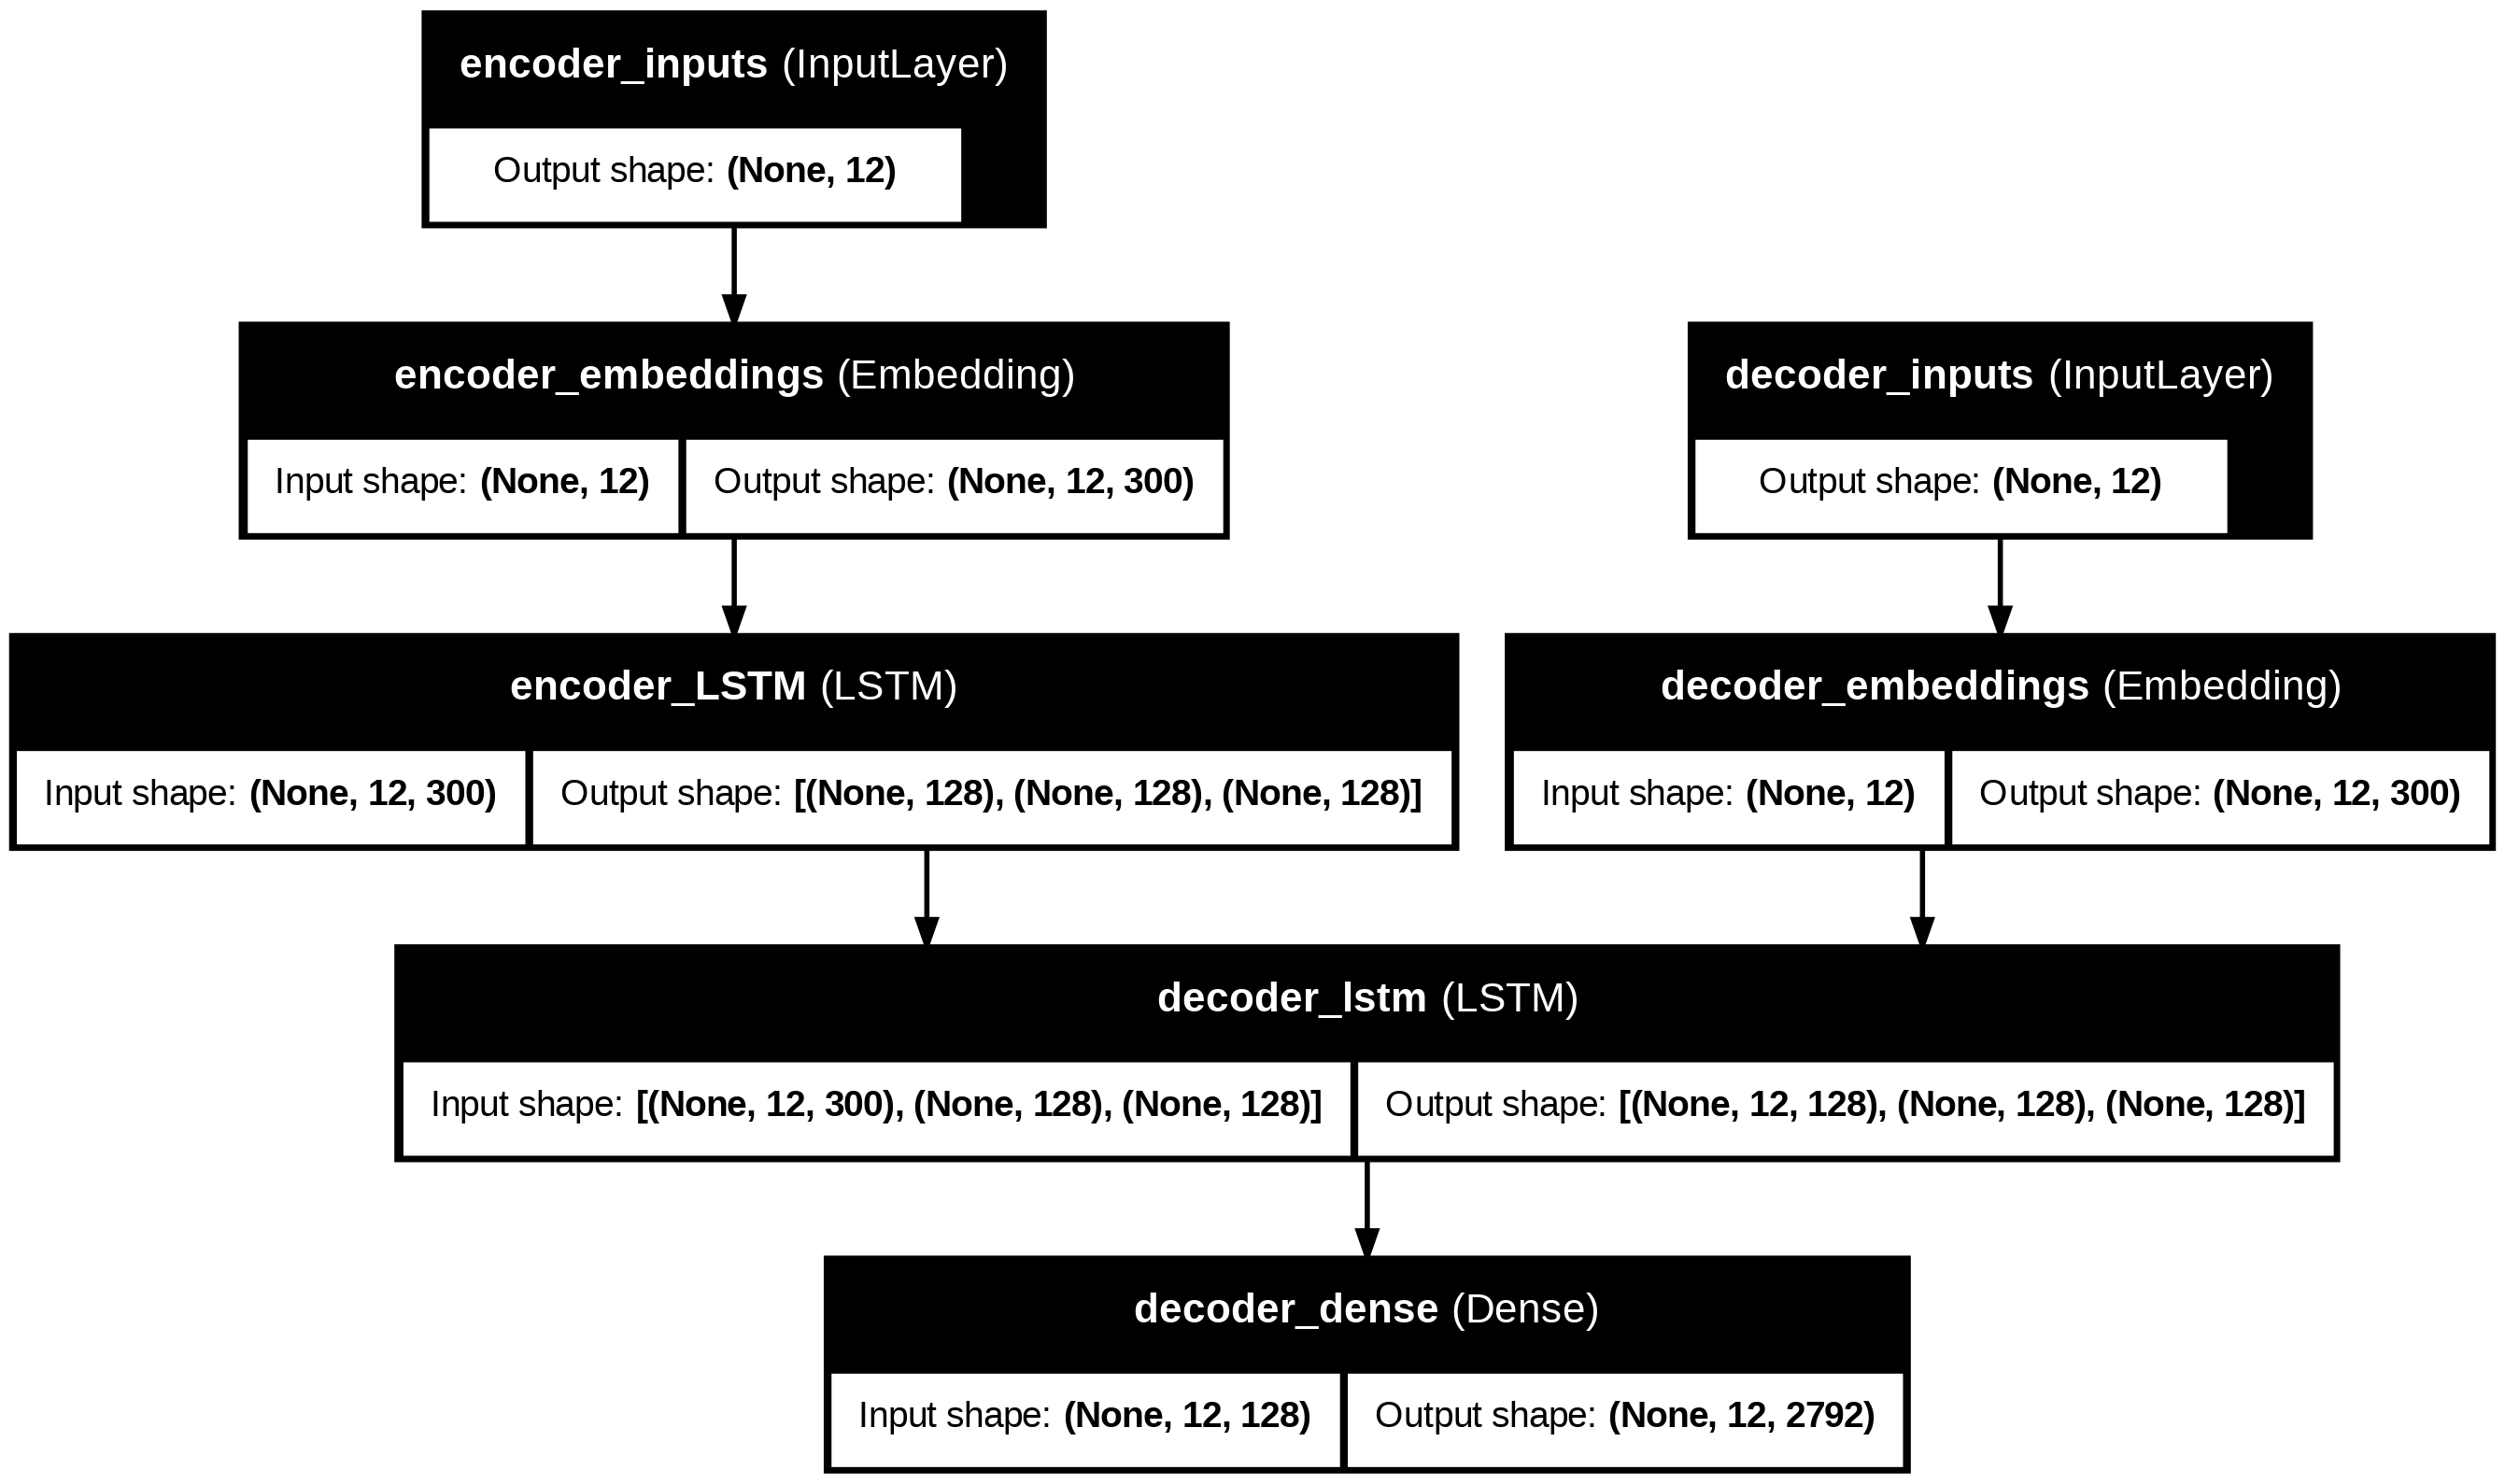

In [ ]:
# INFERENCE model: encoder
encoder_model = Model(encoder_inputs, encoder_state)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

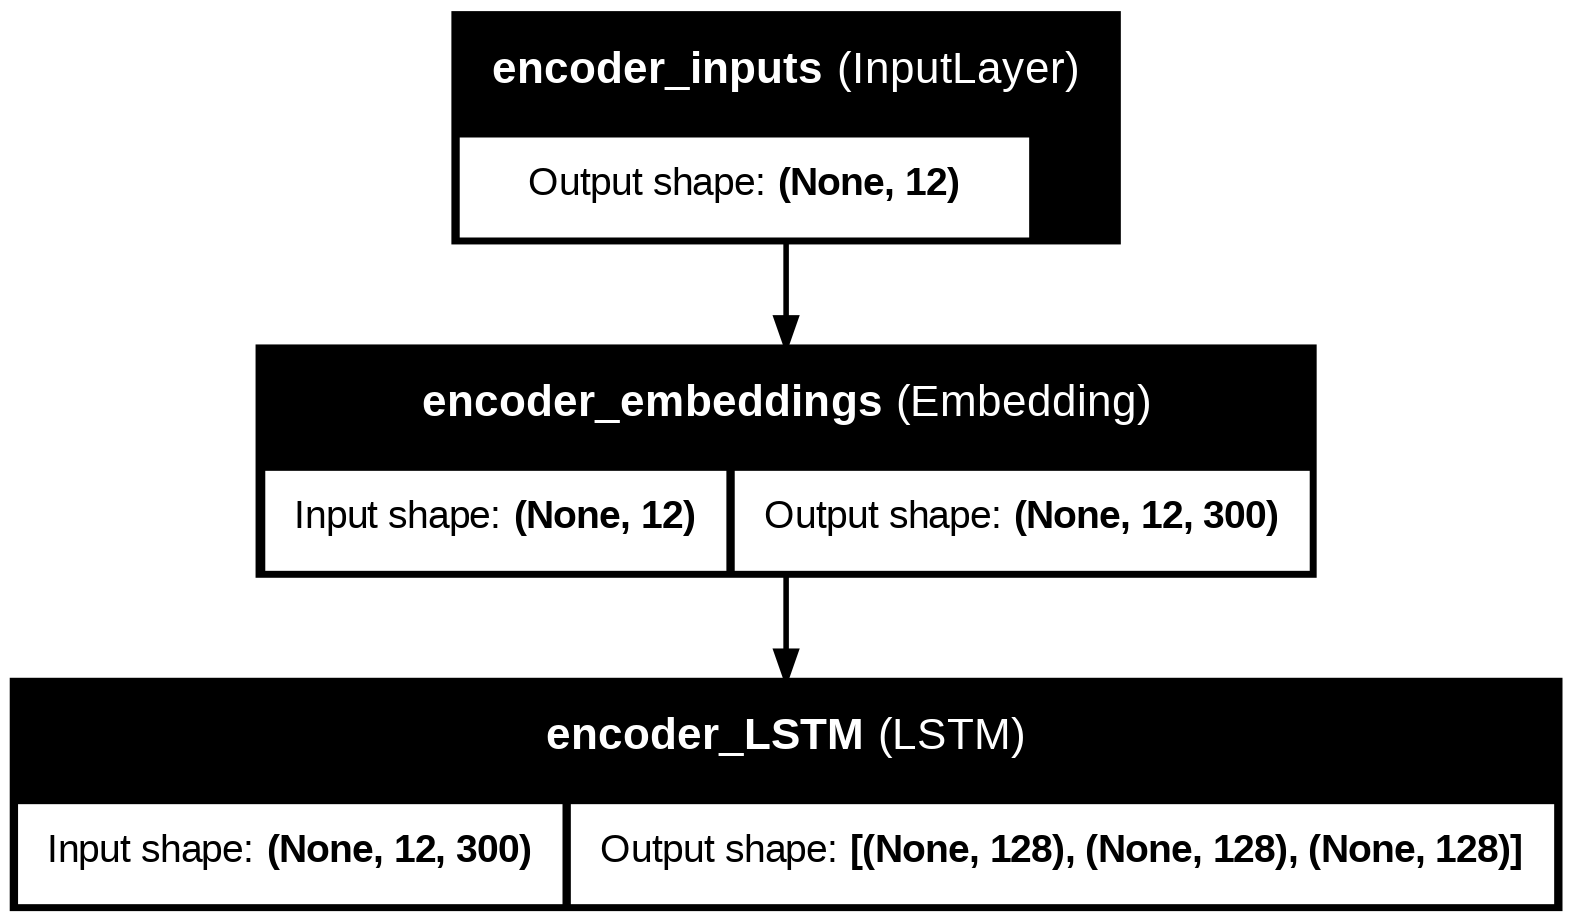

In [ ]:
# INFERENCE model: decoder
decoder_initial_state_h = Input(shape=(n_units,), name="decoder_intial_state_h")
decoder_initial_state_c = Input(shape=(n_units,), name="decoder_intial_state_c")
decoder_initial_state = [decoder_initial_state_h, decoder_initial_state_c]

decoder_inputs_single = Input(shape=(1,), name="decoder_inputs_single") # Single input (word) to decoder
decoder_inputs_embed_single = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, *decoder_state = decoder_lstm_layer(decoder_inputs_embed_single, initial_state=decoder_initial_state)
decoder_outputs = decoder_dense_layer(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_initial_state, [decoder_outputs] + decoder_state)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

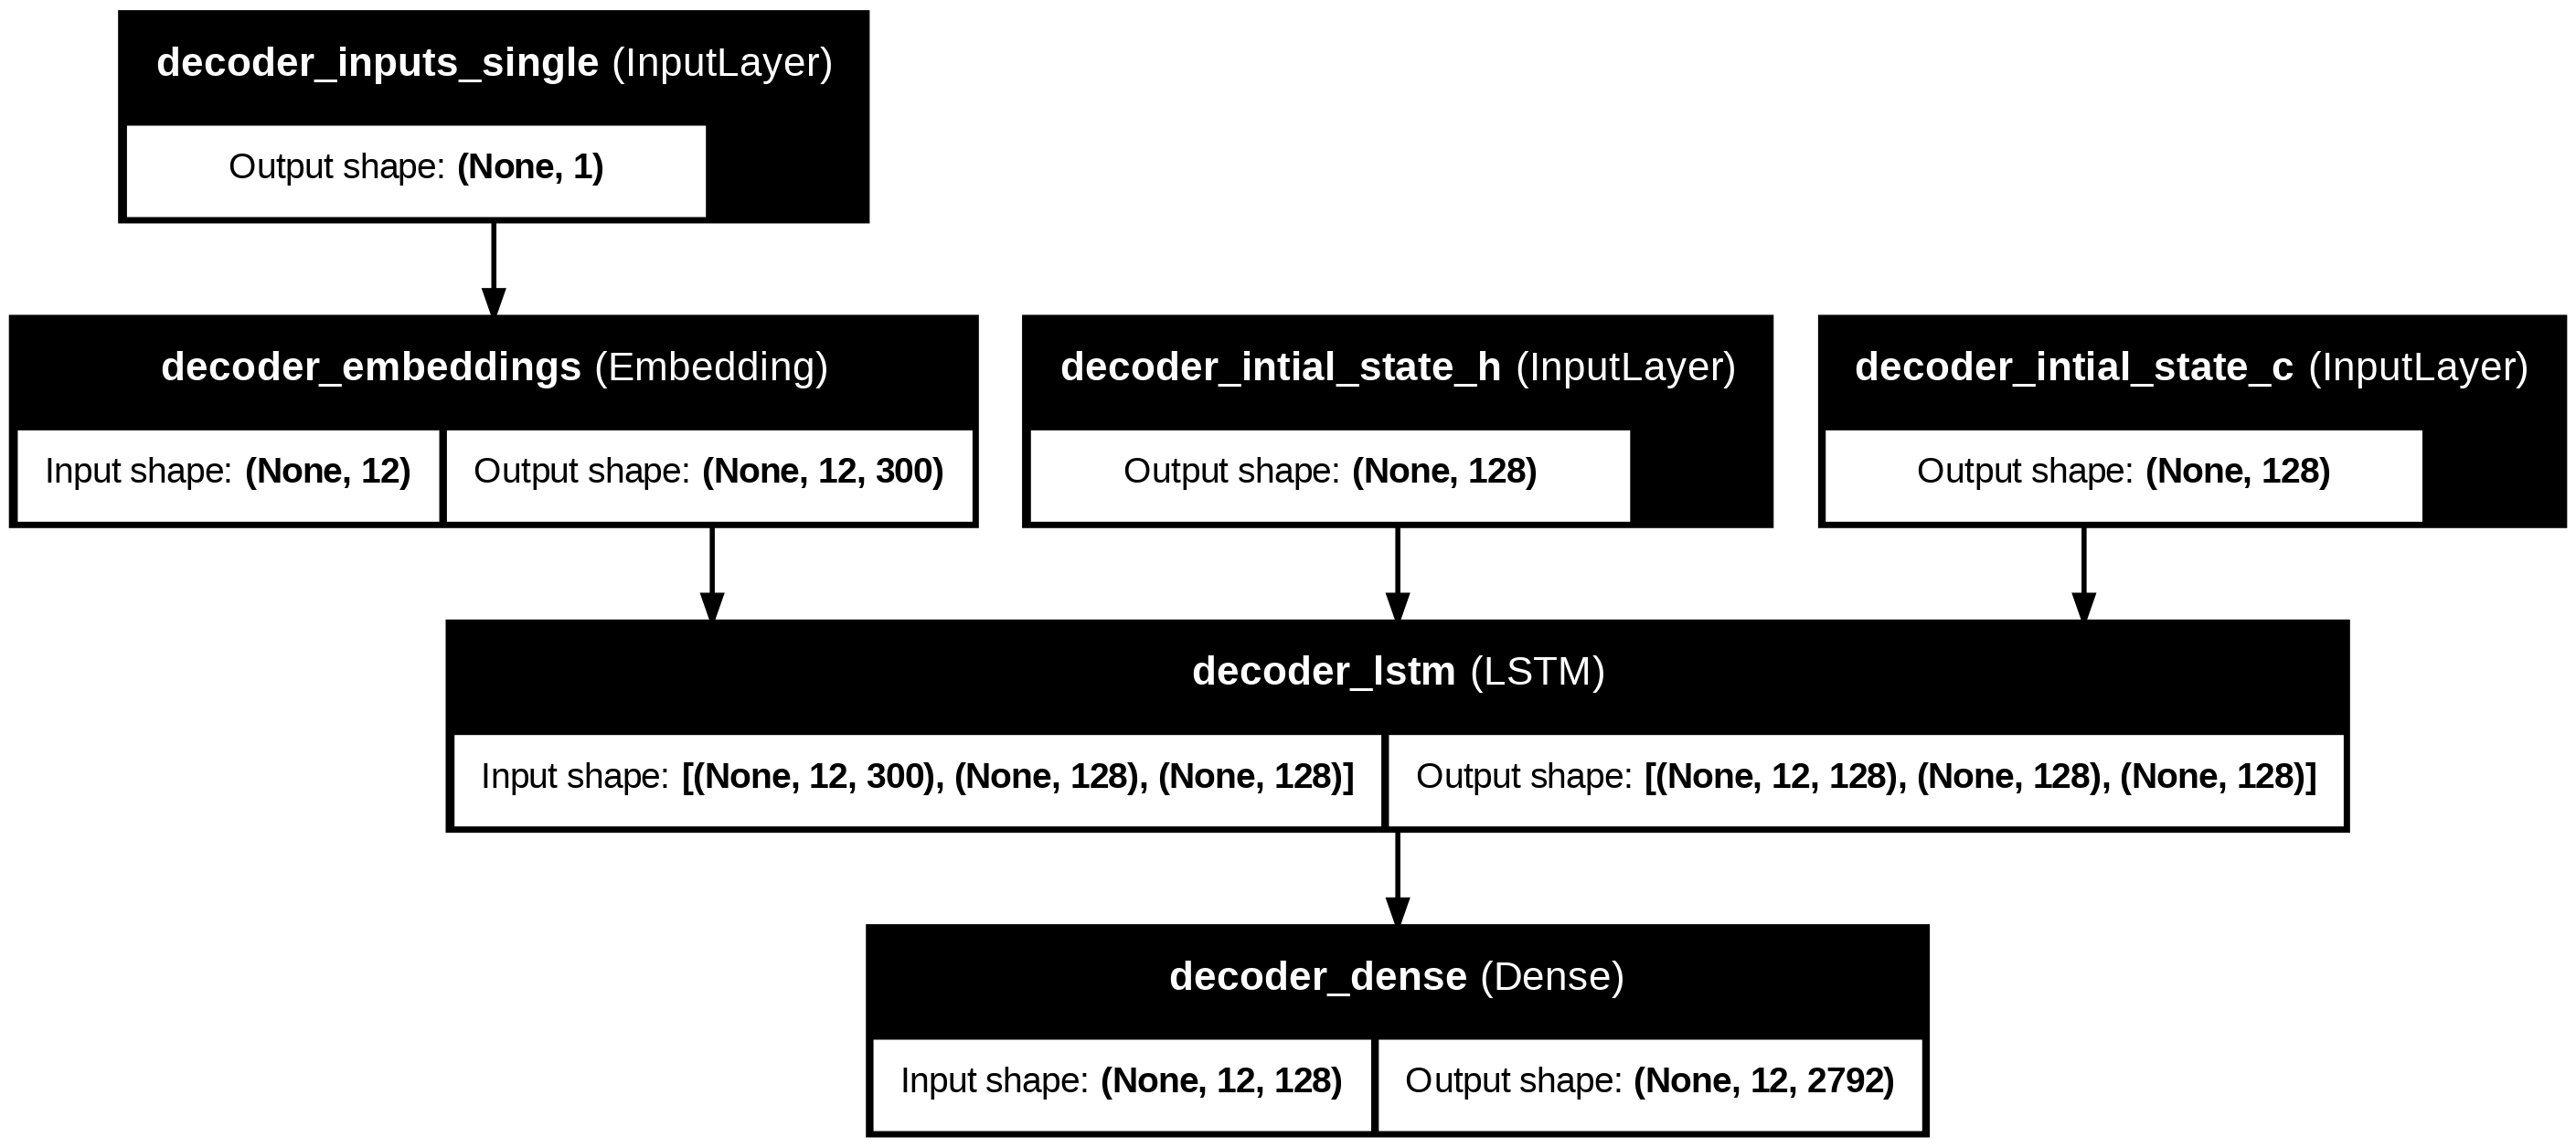

In [ ]:
from keras.callbacks import EarlyStopping, LearningRateScheduler

# Define LearningRateScheduler callback
def lr_schedule(epoch, lr):
    if lr < 3e-4:
      return lr

    if (epoch + 1) % 15 == 0:
      return lr / 3
    else:
      return lr

lr_scheduler = LearningRateScheduler(lr_schedule)


# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation acc
    patience=5,          # Stop after 3 epochs of no improvement
    restore_best_weights=True,
    verbose=1
)

# Fit the model with EarlyStopping
hist = model.fit(
    [in_encoder_pad, in_decoder_pad],
    out_decoder_ohot,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

    Epoch 1/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.5247 - loss: 3.8316 - val_accuracy: 0.6592 - val_loss: 2.1339 - learning_rate: 0.0010
    Epoch 2/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.6550 - loss: 2.0192 - val_accuracy: 0.6712 - val_loss: 1.9574 - learning_rate: 0.0010
    Epoch 3/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.6739 - loss: 1.8323 - val_accuracy: 0.6831 - val_loss: 1.8810 - learning_rate: 0.0010
    Epoch 4/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.6973 - loss: 1.6982 - val_accuracy: 0.6911 - val_loss: 1.8366 - learning_rate: 0.0010
    Epoch 5/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.7004 - loss: 1.6544 - val_accuracy: 0.6946 - val_loss: 1.8036 - learning_rate: 0.0010
    Epoch 6/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.7040 - loss: 1.6034 - val_accuracy: 0.6963 - val_loss: 1.7868 - learning_rate: 0.0010
    Epoch 7/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.7089 - loss: 1.5643 - val_accuracy: 0.6985 - val_loss: 1.7682 - learning_rate: 0.0010
    Epoch 8/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.7079 - loss: 1.5519 - val_accuracy: 0.7000 - val_loss: 1.7518 - learning_rate: 0.0010
    Epoch 9/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.7152 - loss: 1.4941 - val_accuracy: 0.7001 - val_loss: 1.7427 - learning_rate: 0.0010
    Epoch 10/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.7165 - loss: 1.4620 - val_accuracy: 0.7034 - val_loss: 1.7312 - learning_rate: 0.0010
    Epoch 11/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.7165 - loss: 1.4511 - val_accuracy: 0.7032 - val_loss: 1.7262 - learning_rate: 0.0010
    Epoch 12/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.7167 - loss: 1.4382 - val_accuracy: 0.7036 - val_loss: 1.7184 - learning_rate: 0.0010
    Epoch 13/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.7237 - loss: 1.3939 - val_accuracy: 0.7059 - val_loss: 1.7142 - learning_rate: 0.0010
    Epoch 14/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.7244 - loss: 1.3799 - val_accuracy: 0.7044 - val_loss: 1.7110 - learning_rate: 0.0010
    Epoch 15/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7227 - loss: 1.3651 - val_accuracy: 0.7088 - val_loss: 1.7094 - learning_rate: 3.3333e-04
    Epoch 16/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7290 - loss: 1.3322 - val_accuracy: 0.7088 - val_loss: 1.7081 - learning_rate: 3.3333e-04
    Epoch 17/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.7231 - loss: 1.3562 - val_accuracy: 0.7079 - val_loss: 1.7102 - learning_rate: 3.3333e-04
    Epoch 18/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.7260 - loss: 1.3414 - val_accuracy: 0.7088 - val_loss: 1.7068 - learning_rate: 3.3333e-04
    Epoch 19/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7235 - loss: 1.3552 - val_accuracy: 0.7103 - val_loss: 1.7071 - learning_rate: 3.3333e-04
    Epoch 20/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.7278 - loss: 1.3286 - val_accuracy: 0.7100 - val_loss: 1.7055 - learning_rate: 3.3333e-04
    Epoch 21/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7261 - loss: 1.3305 - val_accuracy: 0.7101 - val_loss: 1.7074 - learning_rate: 3.3333e-04
    Epoch 22/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.7289 - loss: 1.3223 - val_accuracy: 0.7104 - val_loss: 1.7068 - learning_rate: 3.3333e-04
    Epoch 23/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.7350 - loss: 1.2961 - val_accuracy: 0.7115 - val_loss: 1.7072 - learning_rate: 3.3333e-04
    Epoch 24/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7283 - loss: 1.3166 - val_accuracy: 0.7113 - val_loss: 1.7092 - learning_rate: 3.3333e-04
    Epoch 25/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.7300 - loss: 1.2991 - val_accuracy: 0.7129 - val_loss: 1.7097 - learning_rate: 3.3333e-04
    Epoch 26/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.7281 - loss: 1.3026 - val_accuracy: 0.7130 - val_loss: 1.7104 - learning_rate: 3.3333e-04
    Epoch 27/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7336 - loss: 1.2732 - val_accuracy: 0.7115 - val_loss: 1.7109 - learning_rate: 3.3333e-04
    Epoch 28/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.7335 - loss: 1.2754 - val_accuracy: 0.7124 - val_loss: 1.7139 - learning_rate: 3.3333e-04
    Epoch 29/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.7335 - loss: 1.2667 - val_accuracy: 0.7121 - val_loss: 1.7135 - learning_rate: 3.3333e-04
    Epoch 30/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.7307 - loss: 1.2858 - val_accuracy: 0.7125 - val_loss: 1.7139 - learning_rate: 1.1111e-04
    Epoch 31/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.7290 - loss: 1.2856 - val_accuracy: 0.7125 - val_loss: 1.7155 - learning_rate: 1.1111e-04
    Epoch 31: early stopping
    Restoring model weights from the end of the best epoch: 26.

La validation accuracy maxima obtenida en la epoca 26 es de 0.7130.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

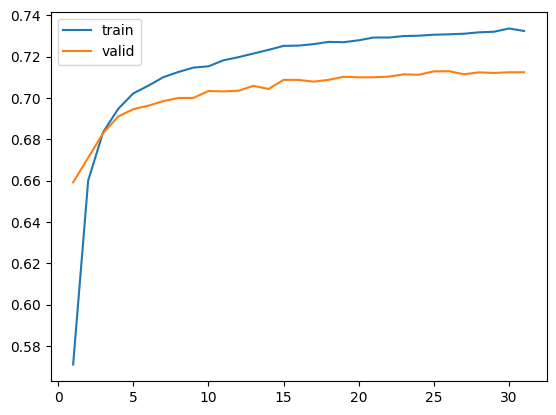

In [79]:
encoder_model.save('encoder_128_lstm.keras')
decoder_model.save('decoder_128_lstm.keras')

---

Vamos a testear el modelo con algunas frases de prueba.

In [ ]:
# Load the model
encoder_model = load_model('encoder_128_bidirectional.keras')
decoder_model = load_model('decoder_128_bidirectional.keras')

In [ ]:
np.random.seed(42)

i = np.random.choice(len(in_encoder_txt))
response = give_response(in_encoder_txt[i], tok, max_input_len)

print('\n')
print('Input:', in_encoder_txt[i])
print('Response:', response)

    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


    Input: i live in new york city i love it here
    Response: i like to read

In [ ]:
input_txt = "Do you read?"
response = give_response(input_txt, tok, max_input_len)

print('\n')
print('Input:', input_txt)
print('Response:', response)

    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


    Input: Do you read?
    Response: i am a teacher

In [ ]:
input_txt = "Do you have any pet?"
response = give_response(input_txt, tok, max_input_len)

print('\n')
print('Input:', input_txt)
print('Response:', response)

    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


    Input: Do you have any pet?
    Response: i am a vegan i am a vegan

In [ ]:
input_txt = "Where are you from?"
response = give_response(input_txt, tok, max_input_len)

print('\n')
print('Input:', input_txt)
print('Response:', response)

    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


    Input: Where are you from?
    Response: i am a vegan

El modelo no performa demasiado bien. Probablemente a la simplicidad de su arquitectura este underfitteando. Vamos a complejizarla y entrenar un nuevo modelo.

---

**Model 2**

Utilizamos 128 neuronas para la capa lstm del encoder al igual que hicimos anteriormente. Ademas la hacemos bidireccional a esta capa, para que el estado que pasa al decoder contenga mayor informacion contextual. Esto nos requiere duplicar la cantidad de unidades en la capa LSTM del decoder para recibir el estado de los pasos forward y backward de la capa bidireccional.

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate
from keras.optimizers import Nadam

n_units = 128

# ENCODER
# Input
encoder_inputs = Input(shape=(max_seq_length,), name="encoder_inputs")

# Embedding
encoder_embedding_layer = Embedding(
          input_dim=vocab_size + 1,  # vocabulary + padding
          output_dim=embed_dim,  # 300 for FastText
          weights=[embedding_matrix],  # includes padding and oov
          trainable=False,
          name="encoder_embeddings"
          )
encoder_inputs_embed = encoder_embedding_layer(encoder_inputs)

# Bidirectional
encoder_lstm_layer = Bidirectional(LSTM(
    n_units,
    return_state=True,
    dropout=0.2,
    recurrent_dropout=0.2,
    name="encoder_LSTM"
    ), name="encoder_bidirectional")
_, forw_h, forw_c, back_h, back_c = encoder_lstm_layer(encoder_inputs_embed)

# Concat
encoder_concat_h_layer = Concatenate(name="concatenate_h")
state_h = encoder_concat_h_layer([forw_h, back_h])
encoder_concat_c_layer = Concatenate(name="concatenate_c")
state_c = encoder_concat_c_layer([forw_c, back_c])
encoder_state = [state_h, state_c]

# DECODER
# Input
decoder_inputs = Input(shape=(max_seq_length,), name="decoder_inputs")

# Embedding
decoder_embedding_layer = Embedding(
          input_dim=vocab_size + 1,  # vocabulary + padding
          output_dim=embed_dim,  # 300 for FastText
          weights=[embedding_matrix],  # includes padding and oov
          trainable=False,
          name="decoder_embeddings"
          )
decoder_inputs_embed = decoder_embedding_layer(decoder_inputs)

# LSTM
decoder_lstm_layer = LSTM(
    n_units*2,
    return_sequences=True,
    return_state=True,
    dropout=0.2,
    recurrent_dropout=0.2,
    name="decoder_lstm"
    )
decoder_outputs, *_ = decoder_lstm_layer(decoder_inputs_embed, initial_state=encoder_state)

# Dense
decoder_dense_layer = Dense(
    vocab_size,
    activation='softmax',
    name="decoder_dense"
    )
decoder_outputs = decoder_dense_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

optimizer = Nadam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

    Model: "functional"
    ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
    ┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
    ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
    │ encoder_inputs            │ (None, 12)             │              0 │ -                      │
    │ (InputLayer)              │                        │                │                        │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ encoder_embeddings        │ (None, 12, 300)        │        837,900 │ encoder_inputs[0][0]   │
    │ (Embedding)               │                        │                │                        │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ decoder_inputs            │ (None, 12)             │              0 │ -                      │
    │ (InputLayer)              │                        │                │                        │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ encoder_bidirectional     │ [(None, 256), (None,   │        439,296 │ encoder_embeddings[0]… │
    │ (Bidirectional)           │ 128), (None, 128),     │                │                        │
    │                           │ (None, 128), (None,    │                │                        │
    │                           │ 128)]                  │                │                        │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ decoder_embeddings        │ (None, 12, 300)        │        837,900 │ decoder_inputs[0][0]   │
    │ (Embedding)               │                        │                │                        │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ concatenate_h             │ (None, 256)            │              0 │ encoder_bidirectional… │
    │ (Concatenate)             │                        │                │ encoder_bidirectional… │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ concatenate_c             │ (None, 256)            │              0 │ encoder_bidirectional… │
    │ (Concatenate)             │                        │                │ encoder_bidirectional… │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ decoder_lstm (LSTM)       │ [(None, 12, 256),      │        570,368 │ decoder_embeddings[0]… │
    │                           │ (None, 256), (None,    │                │ concatenate_h[0][0],   │
    │                           │ 256)]                  │                │ concatenate_c[0][0]    │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ decoder_dense (Dense)     │ (None, 12, 2792)       │        717,544 │ decoder_lstm[0][0]     │
    └───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘
    Total params: 3,403,008 (12.98 MB)
    Trainable params: 1,727,208 (6.59 MB)
    Non-trainable params: 1,675,800 (6.39 MB)

In [ ]:
# TRAIN model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

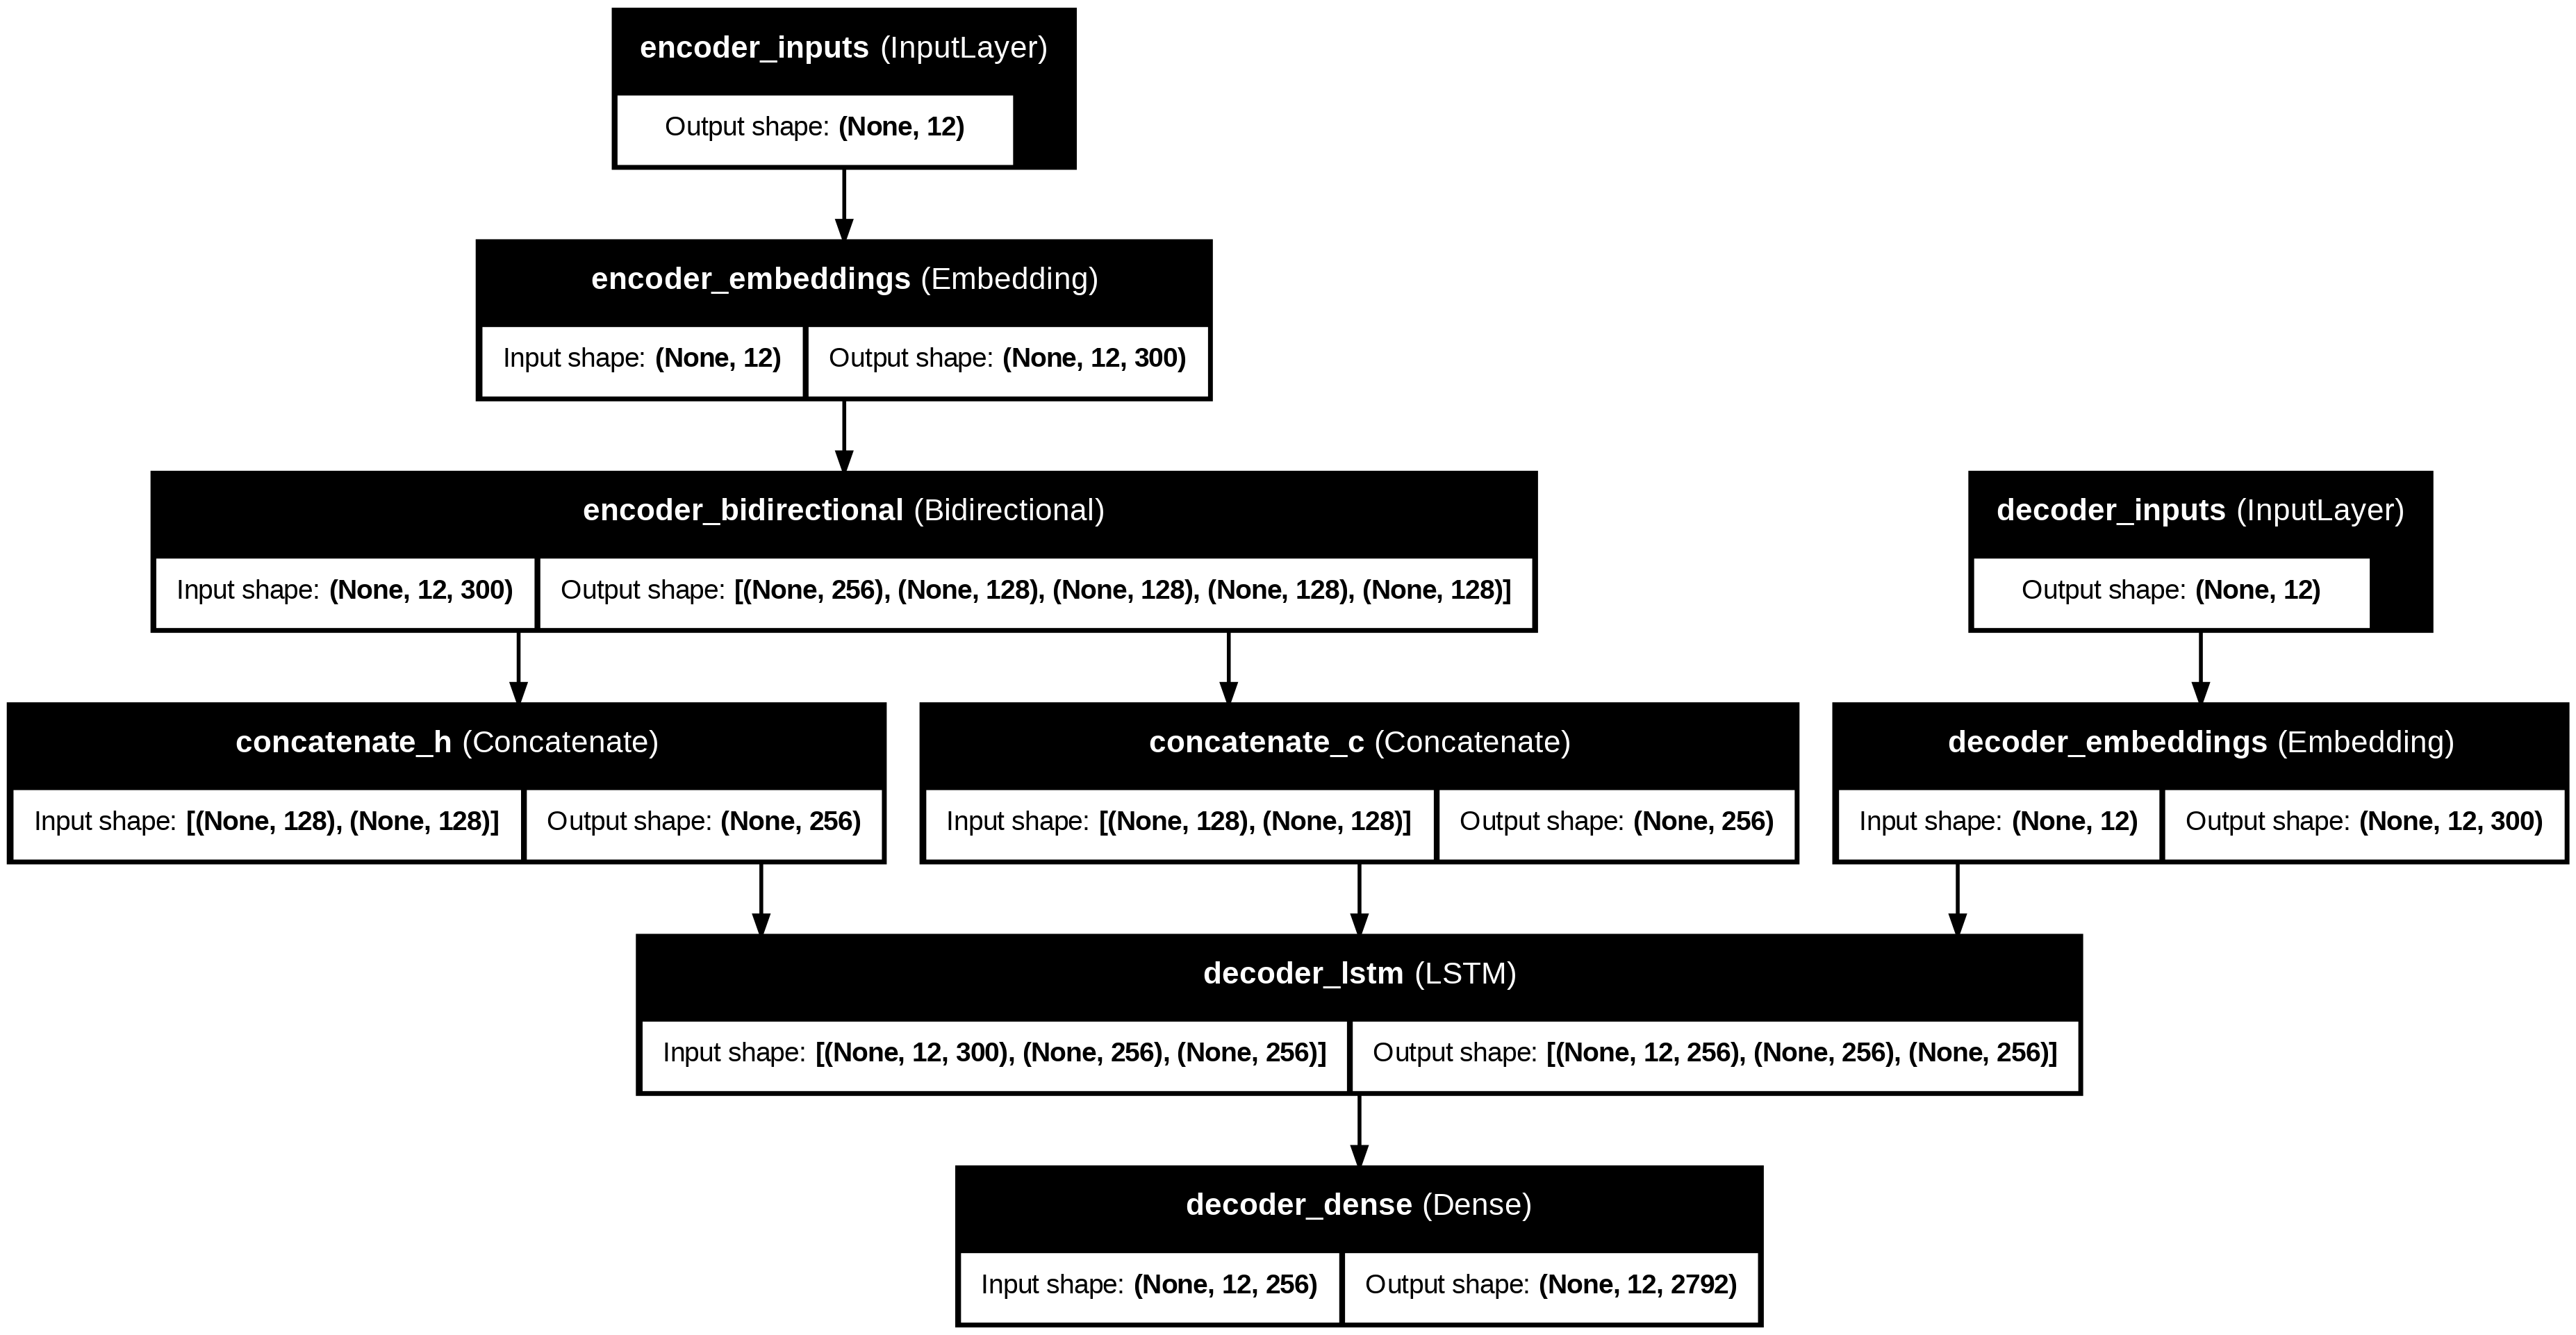

In [ ]:
# INFERENCE model: encoder
encoder_model = Model(encoder_inputs, encoder_state)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

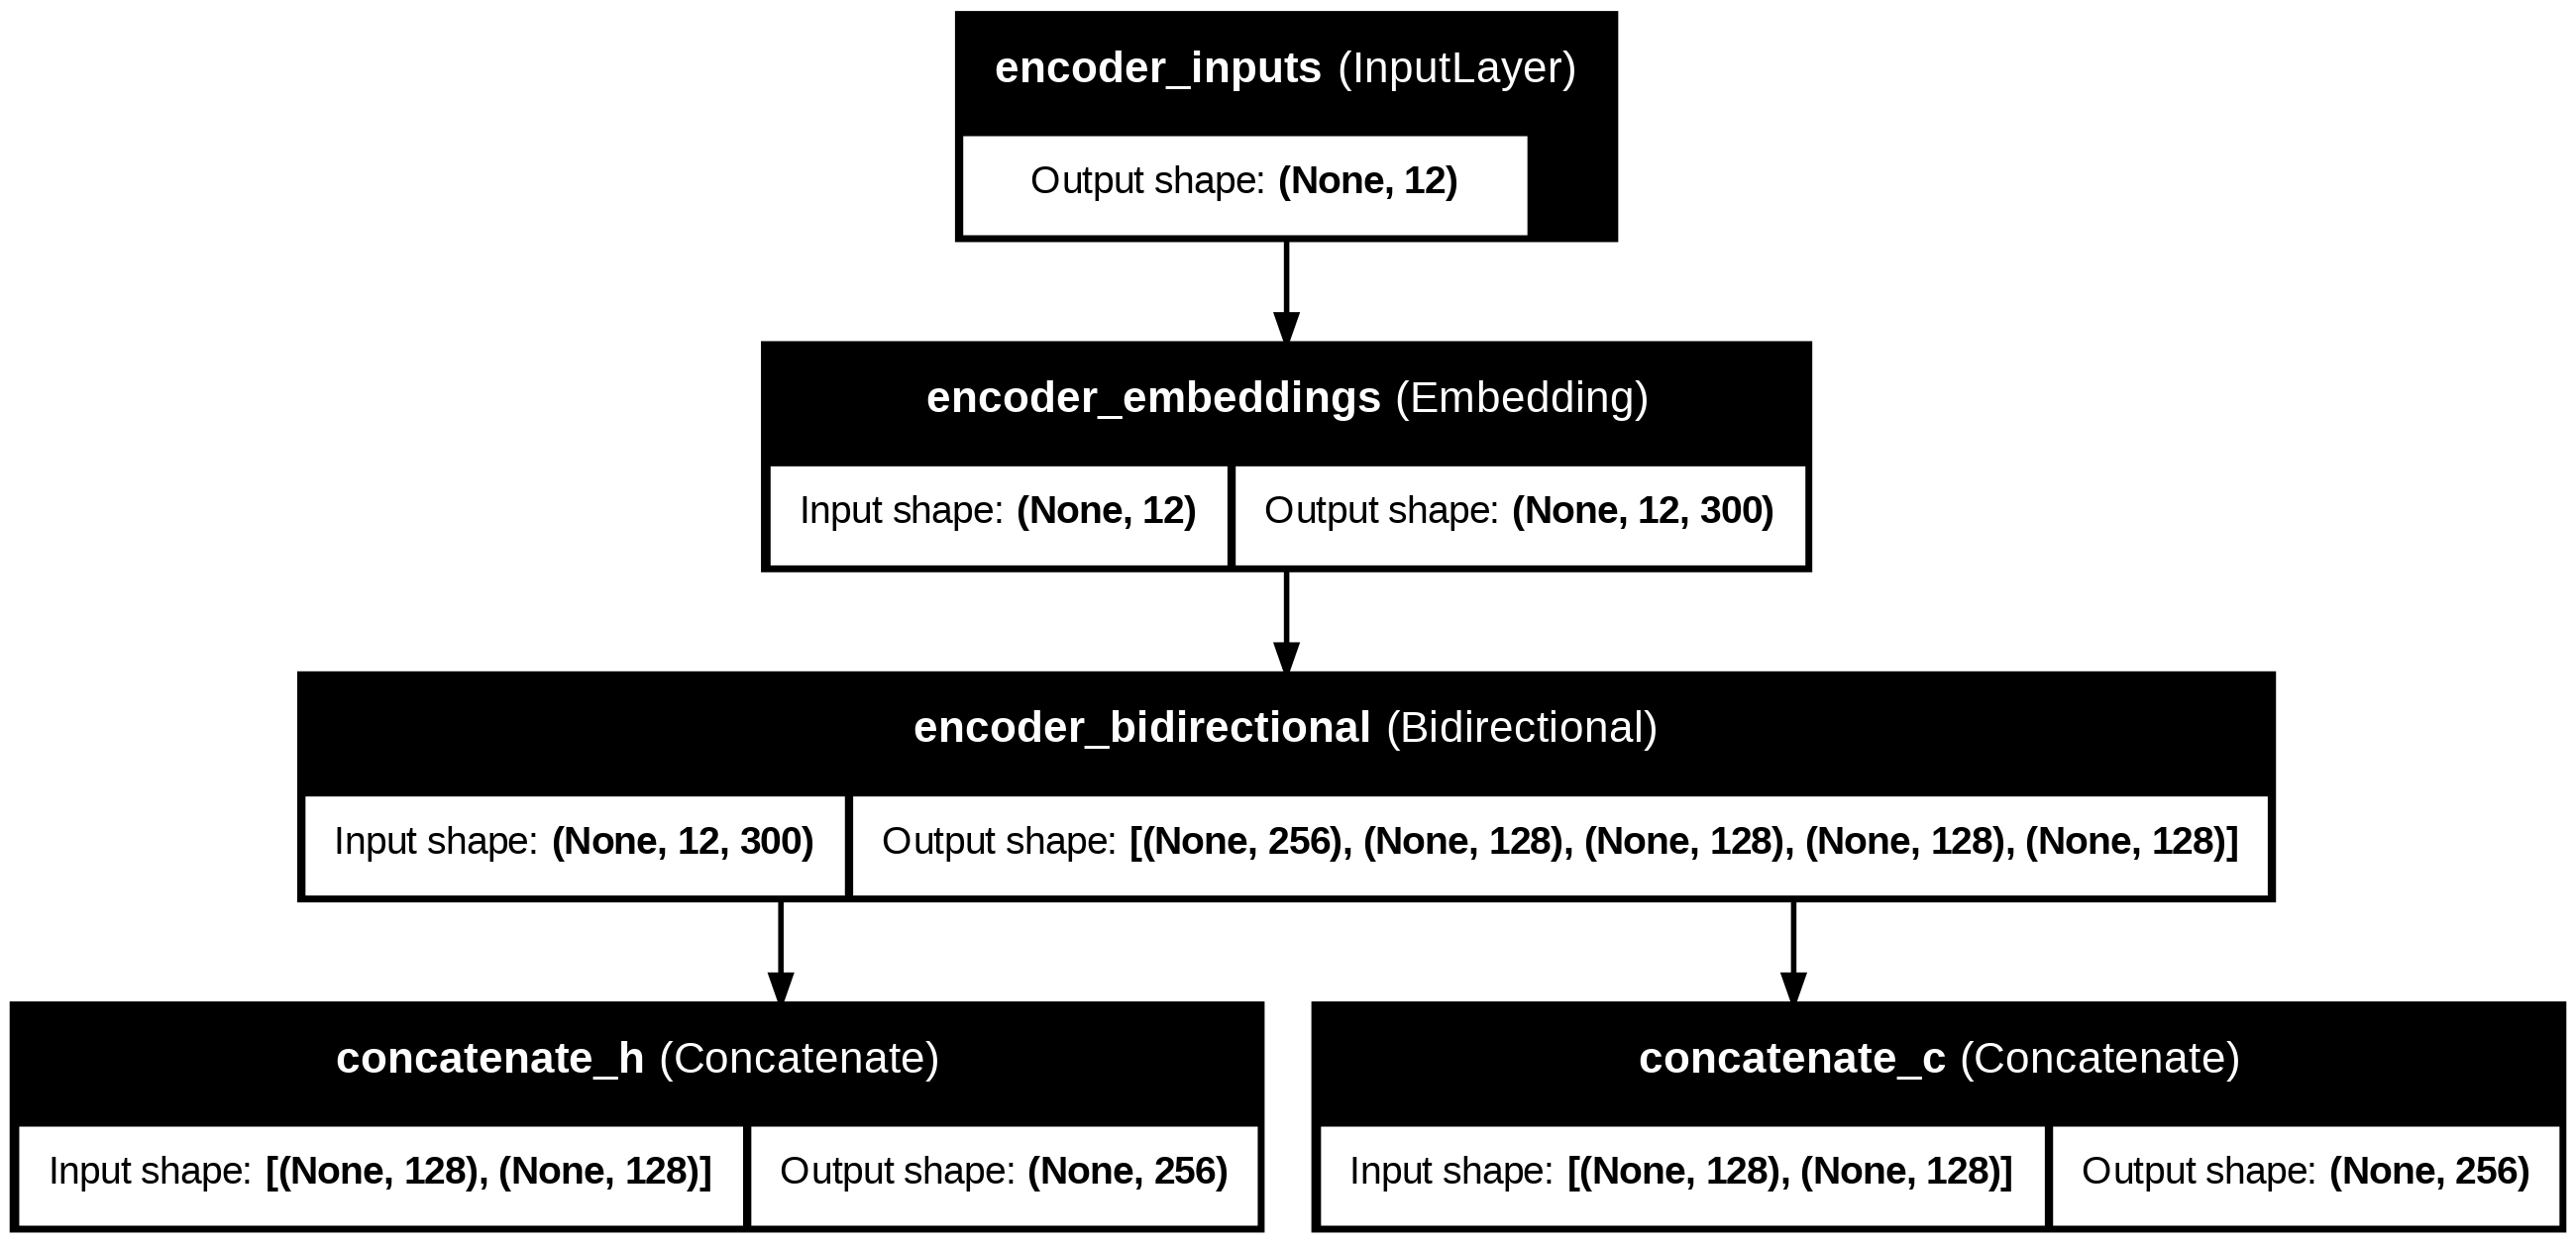

In [ ]:
# INFERENCE model: decoder
decoder_initial_state_h = Input(shape=(n_units*2,), name="decoder_intial_state_h")
decoder_initial_state_c = Input(shape=(n_units*2,), name="decoder_intial_state_c")
decoder_initial_state = [decoder_initial_state_h, decoder_initial_state_c]

decoder_inputs_single = Input(shape=(1,), name="decoder_inputs_single") # Single input (word) to decoder
decoder_inputs_embed_single = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, *decoder_state = decoder_lstm_layer(decoder_inputs_embed_single, initial_state=decoder_initial_state)
decoder_outputs = decoder_dense_layer(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_initial_state, [decoder_outputs] + decoder_state)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

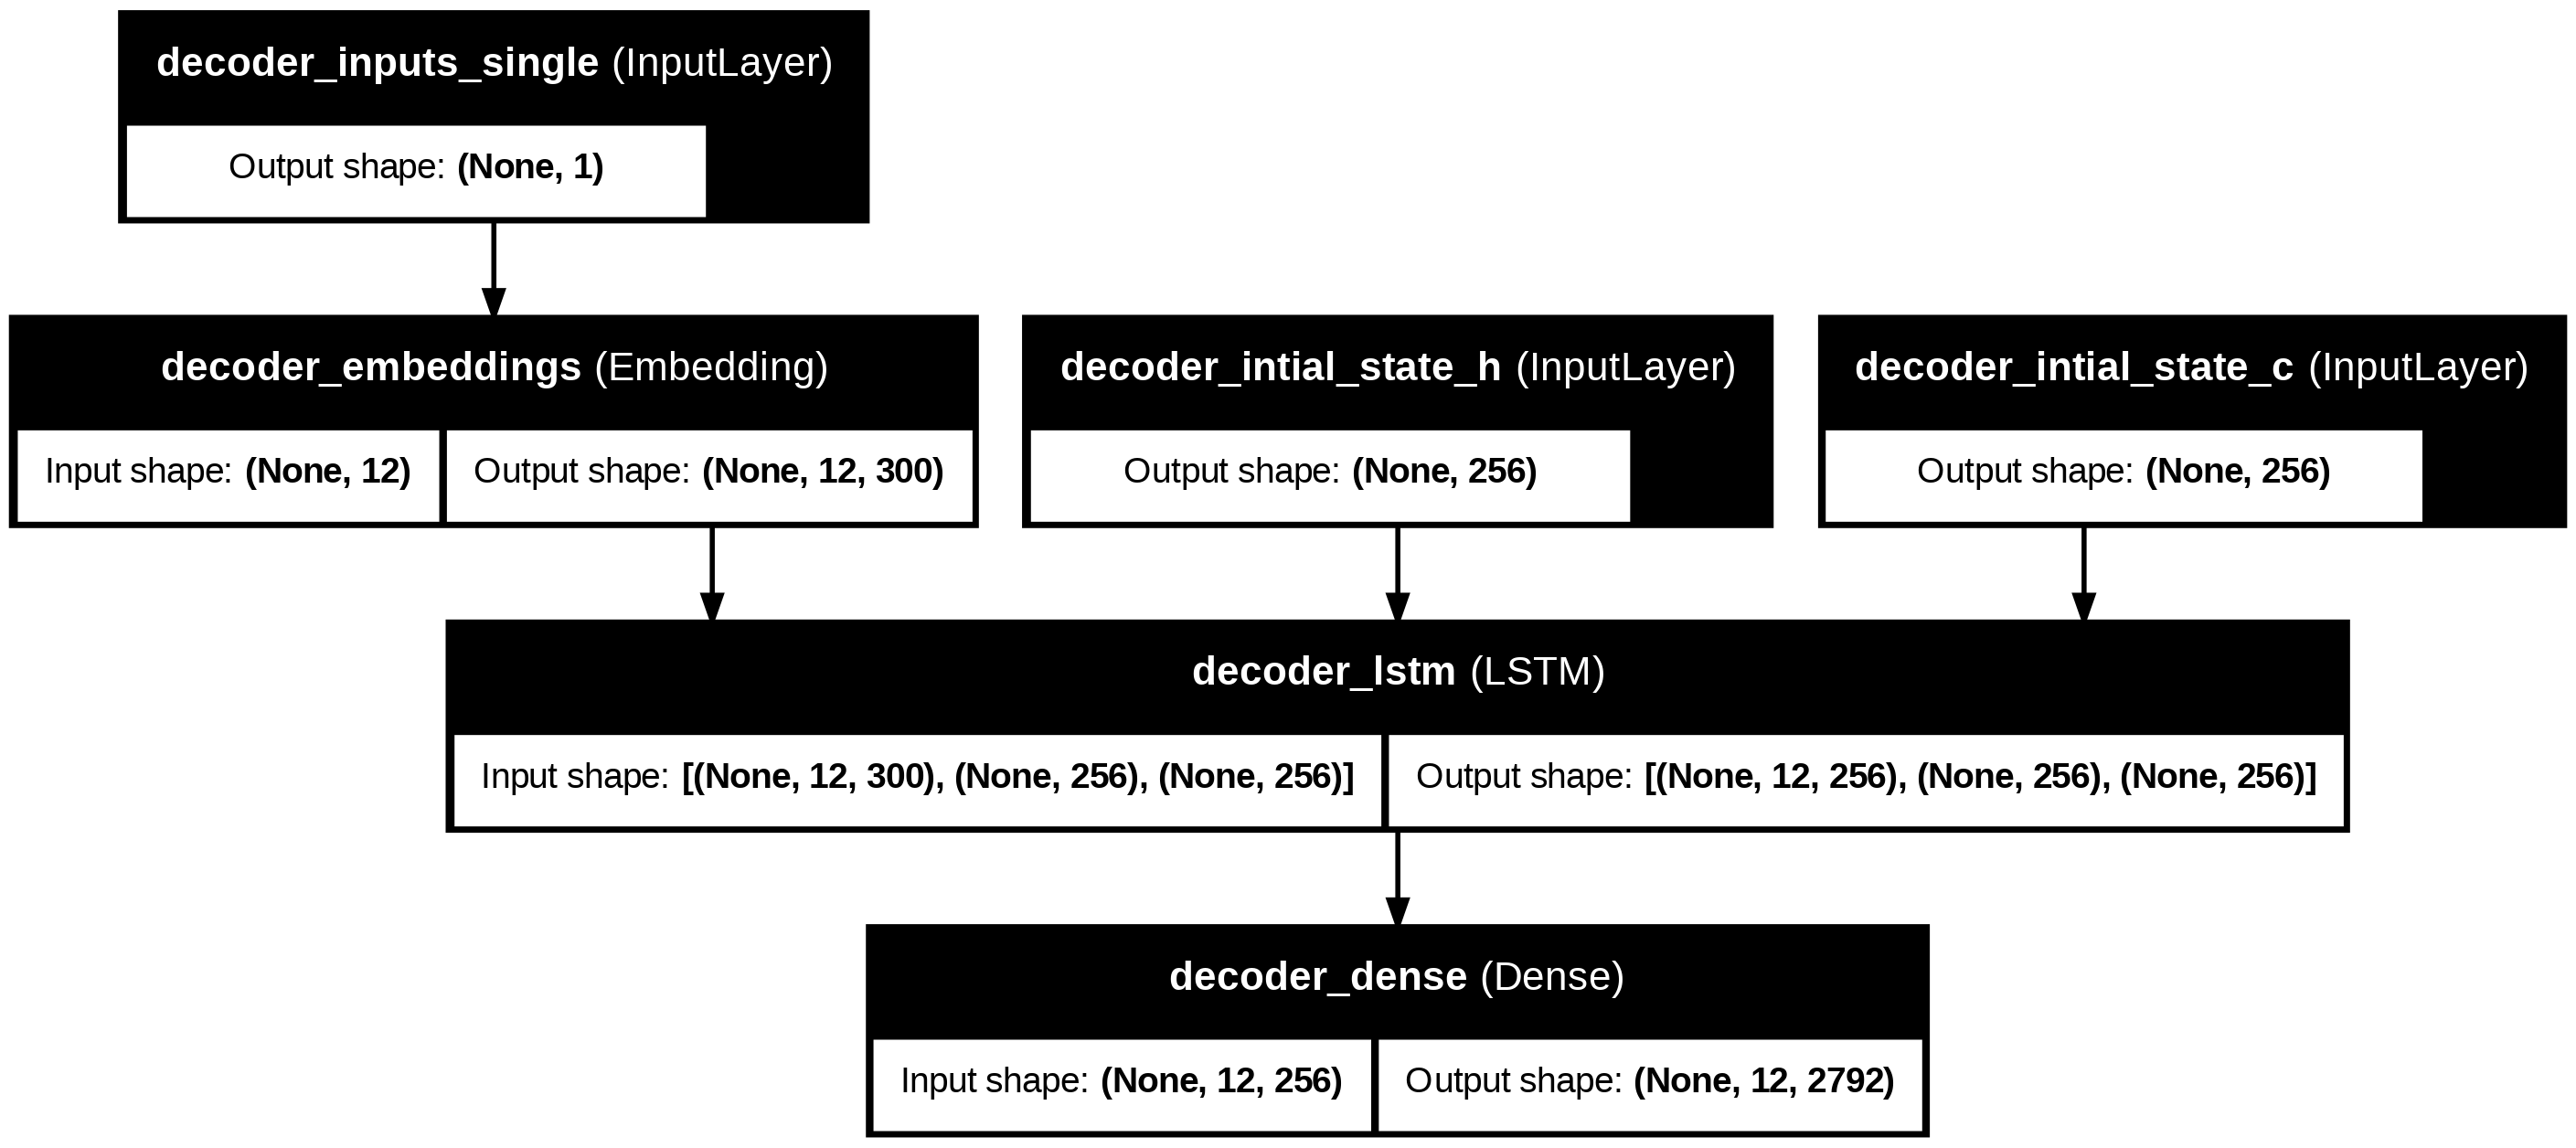

In [ ]:
from keras.callbacks import EarlyStopping, LearningRateScheduler

# Define LearningRateScheduler callback
def lr_schedule(epoch, lr):
    if lr < 3e-4:
      return lr

    if (epoch + 1) % 10 == 0:
      return lr / 3
    else:
      return lr

lr_scheduler = LearningRateScheduler(lr_schedule)


# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation acc
    patience=5,          # Stop after 3 epochs of no improvement
    restore_best_weights=True,
    verbose=1
)

# Fit the model with EarlyStopping
hist = model.fit(
    [in_encoder_pad, in_decoder_pad],
    out_decoder_ohot,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

    Epoch 1/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - accuracy: 0.5579 - loss: 3.2179 - val_accuracy: 0.6785 - val_loss: 1.9680 - learning_rate: 0.0010
    Epoch 2/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 34s 102ms/step - accuracy: 0.6892 - loss: 1.7896 - val_accuracy: 0.6903 - val_loss: 1.8259 - learning_rate: 0.0010
    Epoch 3/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 34s 71ms/step - accuracy: 0.7105 - loss: 1.6127 - val_accuracy: 0.6994 - val_loss: 1.7648 - learning_rate: 0.0010
    Epoch 4/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.7100 - loss: 1.5596 - val_accuracy: 0.7022 - val_loss: 1.7387 - learning_rate: 0.0010
    Epoch 5/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 22s 77ms/step - accuracy: 0.7149 - loss: 1.4902 - val_accuracy: 0.7050 - val_loss: 1.7101 - learning_rate: 0.0010
    Epoch 6/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.7186 - loss: 1.4532 - val_accuracy: 0.7075 - val_loss: 1.6963 - learning_rate: 0.0010
    Epoch 7/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.7281 - loss: 1.3695 - val_accuracy: 0.7075 - val_loss: 1.6915 - learning_rate: 0.0010
    Epoch 8/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.7275 - loss: 1.3478 - val_accuracy: 0.7114 - val_loss: 1.6828 - learning_rate: 0.0010
    Epoch 9/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.7351 - loss: 1.3000 - val_accuracy: 0.7146 - val_loss: 1.6791 - learning_rate: 0.0010
    Epoch 10/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.7343 - loss: 1.2748 - val_accuracy: 0.7156 - val_loss: 1.6734 - learning_rate: 3.3333e-04
    Epoch 11/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.7368 - loss: 1.2559 - val_accuracy: 0.7159 - val_loss: 1.6710 - learning_rate: 3.3333e-04
    Epoch 12/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.7350 - loss: 1.2592 - val_accuracy: 0.7173 - val_loss: 1.6748 - learning_rate: 3.3333e-04
    Epoch 13/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.7384 - loss: 1.2322 - val_accuracy: 0.7180 - val_loss: 1.6745 - learning_rate: 3.3333e-04
    Epoch 14/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.7378 - loss: 1.2275 - val_accuracy: 0.7171 - val_loss: 1.6735 - learning_rate: 3.3333e-04
    Epoch 15/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.7413 - loss: 1.2109 - val_accuracy: 0.7172 - val_loss: 1.6775 - learning_rate: 3.3333e-04
    Epoch 16/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - accuracy: 0.7395 - loss: 1.2169 - val_accuracy: 0.7173 - val_loss: 1.6799 - learning_rate: 3.3333e-04
    Epoch 17/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.7393 - loss: 1.2098 - val_accuracy: 0.7171 - val_loss: 1.6782 - learning_rate: 3.3333e-04
    Epoch 18/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.7419 - loss: 1.1883 - val_accuracy: 0.7200 - val_loss: 1.6796 - learning_rate: 3.3333e-04
    Epoch 19/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.7408 - loss: 1.1834 - val_accuracy: 0.7195 - val_loss: 1.6813 - learning_rate: 3.3333e-04
    Epoch 20/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.7465 - loss: 1.1535 - val_accuracy: 0.7194 - val_loss: 1.6812 - learning_rate: 1.1111e-04
    Epoch 21/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.7454 - loss: 1.1539 - val_accuracy: 0.7197 - val_loss: 1.6824 - learning_rate: 1.1111e-04
    Epoch 22/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.7419 - loss: 1.1742 - val_accuracy: 0.7206 - val_loss: 1.6839 - learning_rate: 1.1111e-04
    Epoch 23/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.7448 - loss: 1.1594 - val_accuracy: 0.7194 - val_loss: 1.6842 - learning_rate: 1.1111e-04
    Epoch 24/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.7459 - loss: 1.1471 - val_accuracy: 0.7205 - val_loss: 1.6845 - learning_rate: 1.1111e-04
    Epoch 25/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.7444 - loss: 1.1519 - val_accuracy: 0.7203 - val_loss: 1.6861 - learning_rate: 1.1111e-04
    Epoch 26/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.7484 - loss: 1.1388 - val_accuracy: 0.7202 - val_loss: 1.6876 - learning_rate: 1.1111e-04
    Epoch 27/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - accuracy: 0.7428 - loss: 1.1552 - val_accuracy: 0.7203 - val_loss: 1.6894 - learning_rate: 1.1111e-04
    Epoch 27: early stopping
    Restoring model weights from the end of the best epoch: 22.

La mayor validation accuracy obtenida es 0.7206, algo mayor que en el modelo anterior.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

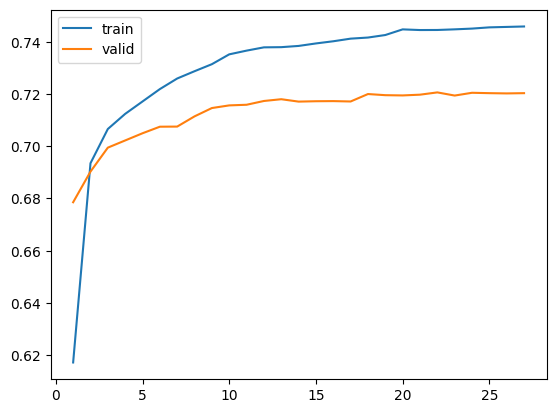

In [40]:
encoder_model.save('encoder_128_bidirectional.keras')
decoder_model.save('decoder_128_bidirectional.keras')

---

Vamos a evaluar la performance del modelo en las mismas frases de testeo utilizadas anteriormente.

In [28]:
# Load the model
encoder_model = load_model('encoder_128_bidirectional.keras')
decoder_model = load_model('decoder_128_bidirectional.keras')

In [ ]:
np.random.seed(42)

i = np.random.choice(len(in_encoder_txt))
response = give_response(in_encoder_txt[i], tok, max_input_len)

print('\n')
print('Input:', in_encoder_txt[i])
print('Response:', response)

    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


    Input: i live in new york city i love it here
    Response: i like to go to the beach

In [ ]:
input_txt = "Do you read?"
response = give_response(input_txt, tok, max_input_len)

print('\n')
print('Input:', input_txt)
print('Response:', response)

    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


    Input: Do you read?
    Response: i like to read

In [ ]:
input_txt = "Do you have any pet?"
response = give_response(input_txt, tok, max_input_len)

print('\n')
print('Input:', input_txt)
print('Response:', response)

    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


    Input: Do you have any pet?
    Response: i like to play video games

In [ ]:
input_txt = "Where are you from?"
response = give_response(input_txt, tok, max_input_len)

print('\n')
print('Input:', input_txt)
print('Response:', response)

    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


    Input: Where are you from?
    Response: i am a vegan i am a vegan

Podemos observar que las respuestas mejoraron levemente, pero aun asi la mayoria carece de sentido. La unica que tiene una respuesta coherente es a la pregunta "Do you read?".

Vamos a incrementar la complejidad del modelo duplicando la cantidad de unidades en ambas capas LSTM y manteniendo la bidireccional en el encoder.

***

**Model 3**

Utilizamos 256 neuronas para la capa lstm del encoder al igual que hicimos anteriormente. Ademas mantenemos la bidireccional, para que el estado que pasa al decoder contenga mayor informacion contextual. La cantidad de unidades en la capa LSTM del decoder es en este caso 512.

In [89]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate
from keras.optimizers import Nadam

n_units = 256

# ENCODER
# Input
encoder_inputs = Input(shape=(max_seq_length,), name="encoder_inputs")

# Embedding
encoder_embedding_layer = Embedding(
          input_dim=vocab_size + 1,  # vocabulary + padding
          output_dim=embed_dim,  # 300 for FastText
          weights=[embedding_matrix],  # includes padding and oov
          trainable=False,
          name="encoder_embeddings"
          )
encoder_inputs_embed = encoder_embedding_layer(encoder_inputs)

# Bidirectional
encoder_lstm_layer = Bidirectional(LSTM(
    n_units,
    return_state=True,
    dropout=0.2,
    recurrent_dropout=0.2,
    name="encoder_LSTM"
    ), name="encoder_bidirectional")
_, forw_h, forw_c, back_h, back_c = encoder_lstm_layer(encoder_inputs_embed)

# Concat
encoder_concat_h_layer = Concatenate(name="concatenate_h")
state_h = encoder_concat_h_layer([forw_h, back_h])
encoder_concat_c_layer = Concatenate(name="concatenate_c")
state_c = encoder_concat_c_layer([forw_c, back_c])
encoder_state = [state_h, state_c]

# DECODER
# Input
decoder_inputs = Input(shape=(max_seq_length,), name="decoder_inputs")

# Embedding
decoder_embedding_layer = Embedding(
          input_dim=vocab_size + 1,  # vocabulary + padding
          output_dim=embed_dim,  # 300 for FastText
          weights=[embedding_matrix],  # includes padding and oov
          trainable=False,
          name="decoder_embeddings"
          )
decoder_inputs_embed = decoder_embedding_layer(decoder_inputs)

# LSTM
decoder_lstm_layer = LSTM(
    n_units*2,
    return_sequences=True,
    return_state=True,
    dropout=0.2,
    recurrent_dropout=0.2,
    name="decoder_lstm"
    )
decoder_outputs, *_ = decoder_lstm_layer(decoder_inputs_embed, initial_state=encoder_state)

# Dense
decoder_dense_layer = Dense(
    vocab_size,
    activation='softmax',
    name="decoder_dense"
    )
decoder_outputs = decoder_dense_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

optimizer = Nadam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, 12)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_embeddings        │ (None, 12, 300)        │        837,900 │ encoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, 12)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bidirectional     │ [(None, 512), (None,   │      1,140,736 │ encoder_embeddings[0]… │
│ (Bidirectional)           │ 256), (None, 256),     │                │                        │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embeddings        │ (None, 12, 300)        │        837,900 │ decoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_h             │ (None, 512)            │              0 │ encoder_bidirectional… │
│ (Concatenate)             │                        │                │ encoder_bidirectional… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_c             │ (None, 512)            │              0 │ encoder_bidirectional… │
│ (Concatenate)             │                        │                │ encoder_bidirectional… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_lstm (LSTM)       │ [(None, 12, 512),      │      1,665,024 │ decoder_embeddings[0]… │
│                           │ (None, 512), (None,    │                │ concatenate_h[0][0],   │
│                           │ 512)]                  │                │ concatenate_c[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_dense (Dense)     │ (None, 12, 2792)       │      1,432,296 │ decoder_lstm[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,913,856 (22.56 MB)

 Trainable params: 4,238,056 (16.17 MB)

 Non-trainable params: 1,675,800 (6.39 MB)

    Model: "functional_6"
    ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
    ┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
    ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
    │ encoder_inputs            │ (None, 12)             │              0 │ -                      │
    │ (InputLayer)              │                        │                │                        │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ encoder_embeddings        │ (None, 12, 300)        │        837,900 │ encoder_inputs[0][0]   │
    │ (Embedding)               │                        │                │                        │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ decoder_inputs            │ (None, 12)             │              0 │ -                      │
    │ (InputLayer)              │                        │                │                        │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ encoder_bidirectional     │ [(None, 512), (None,   │      1,140,736 │ encoder_embeddings[0]… │
    │ (Bidirectional)           │ 256), (None, 256),     │                │                        │
    │                           │ (None, 256), (None,    │                │                        │
    │                           │ 256)]                  │                │                        │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ decoder_embeddings        │ (None, 12, 300)        │        837,900 │ decoder_inputs[0][0]   │
    │ (Embedding)               │                        │                │                        │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ concatenate_h             │ (None, 512)            │              0 │ encoder_bidirectional… │
    │ (Concatenate)             │                        │                │ encoder_bidirectional… │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ concatenate_c             │ (None, 512)            │              0 │ encoder_bidirectional… │
    │ (Concatenate)             │                        │                │ encoder_bidirectional… │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ decoder_lstm (LSTM)       │ [(None, 12, 512),      │      1,665,024 │ decoder_embeddings[0]… │
    │                           │ (None, 512), (None,    │                │ concatenate_h[0][0],   │
    │                           │ 512)]                  │                │ concatenate_c[0][0]    │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ decoder_dense (Dense)     │ (None, 12, 2792)       │      1,432,296 │ decoder_lstm[0][0]     │
    └───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘
    Total params: 5,913,856 (22.56 MB)
    Trainable params: 4,238,056 (16.17 MB)
    Non-trainable params: 1,675,800 (6.39 MB)

In [ ]:
# TRAIN model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

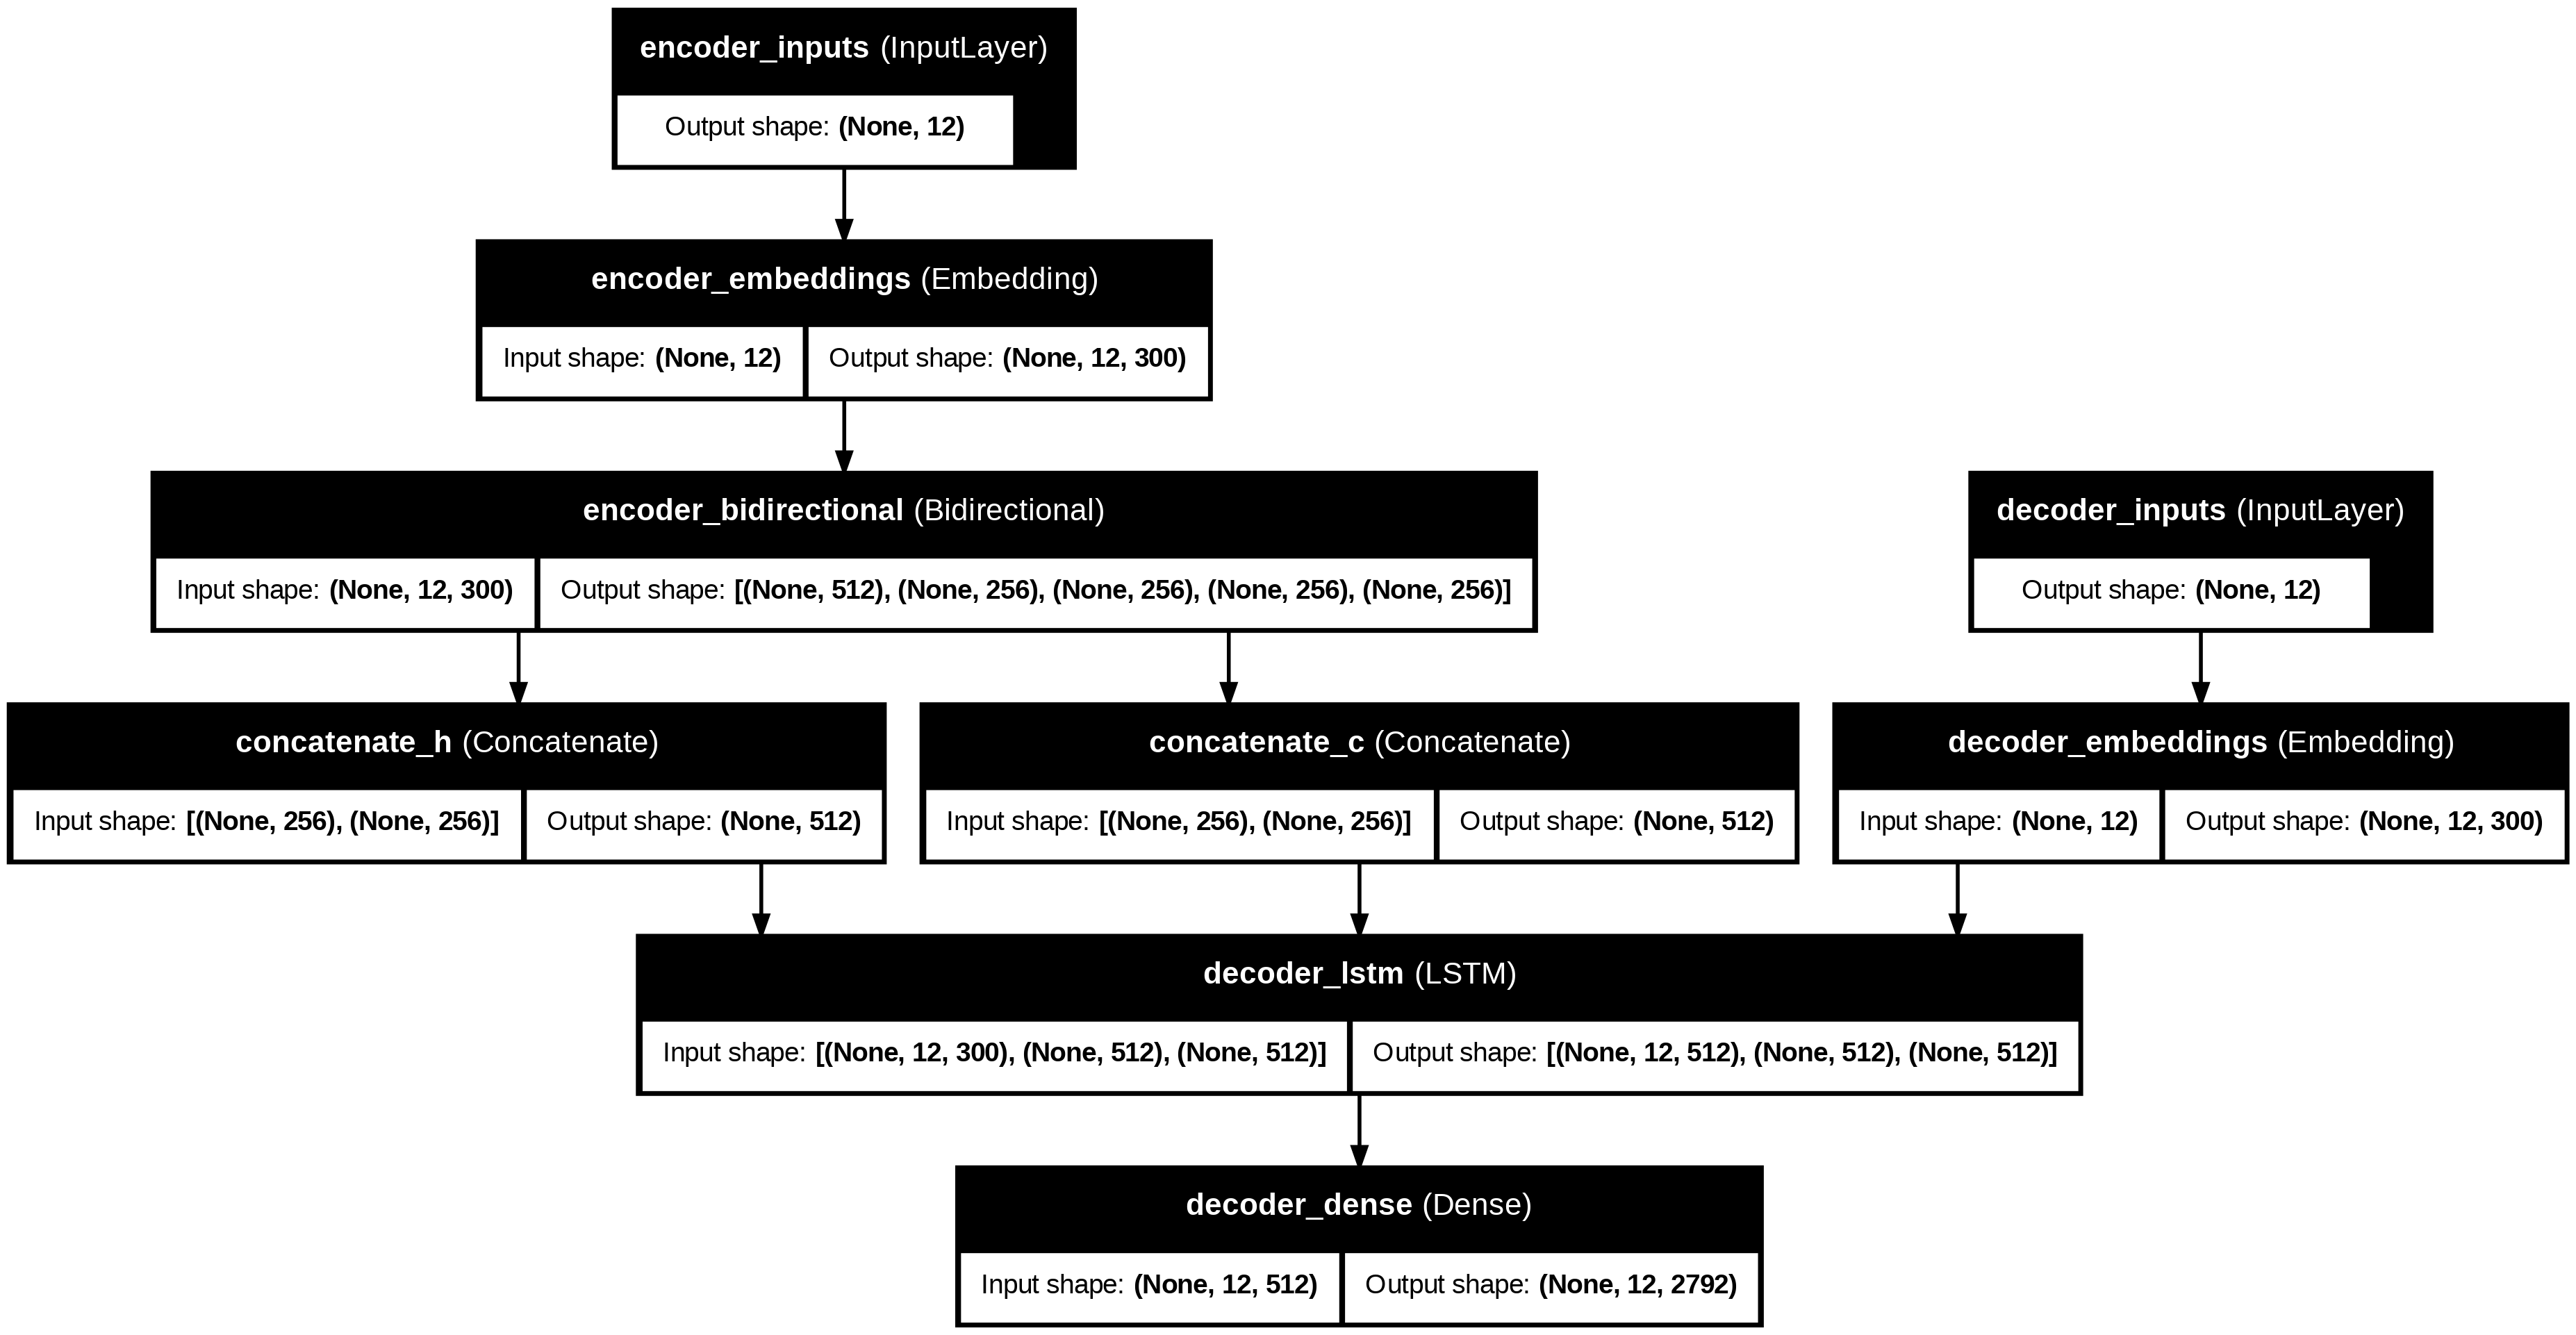

In [ ]:
# INFERENCE model: encoder
encoder_model = Model(encoder_inputs, encoder_state)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

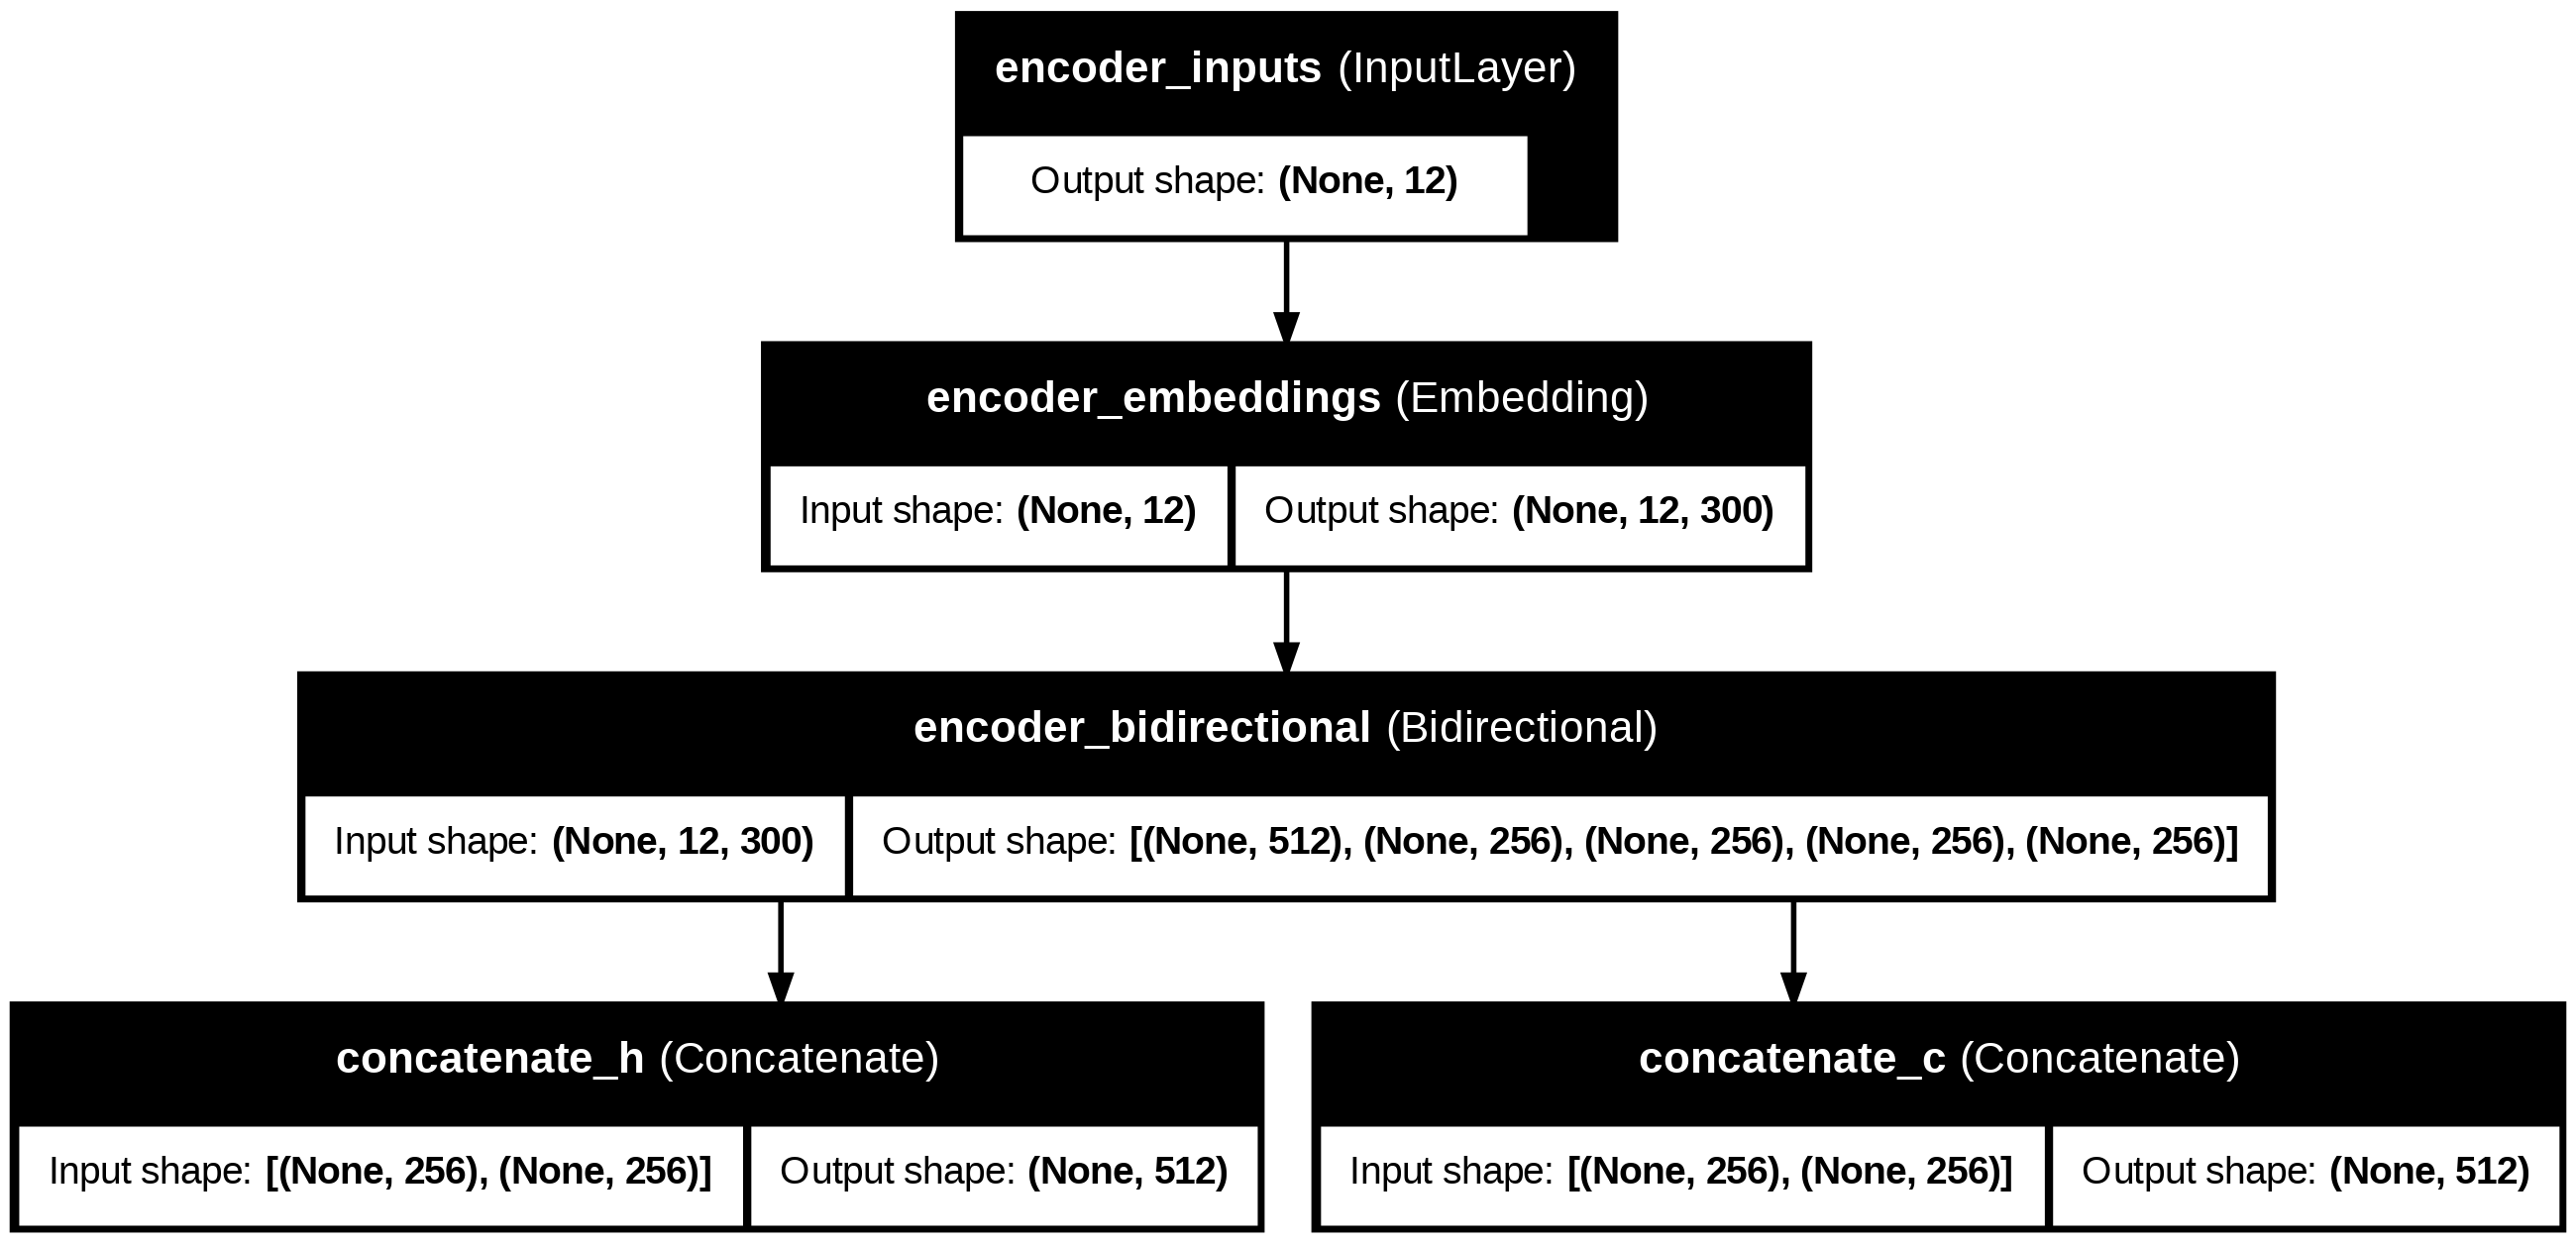

In [ ]:
# INFERENCE model: decoder
decoder_initial_state_h = Input(shape=(n_units*2,), name="decoder_intial_state_h")
decoder_initial_state_c = Input(shape=(n_units*2,), name="decoder_intial_state_c")
decoder_initial_state = [decoder_initial_state_h, decoder_initial_state_c]

decoder_inputs_single = Input(shape=(1,), name="decoder_inputs_single") # Single input (word) to decoder
decoder_inputs_embed_single = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, *decoder_state = decoder_lstm_layer(decoder_inputs_embed_single, initial_state=decoder_initial_state)
decoder_outputs = decoder_dense_layer(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_initial_state, [decoder_outputs] + decoder_state)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

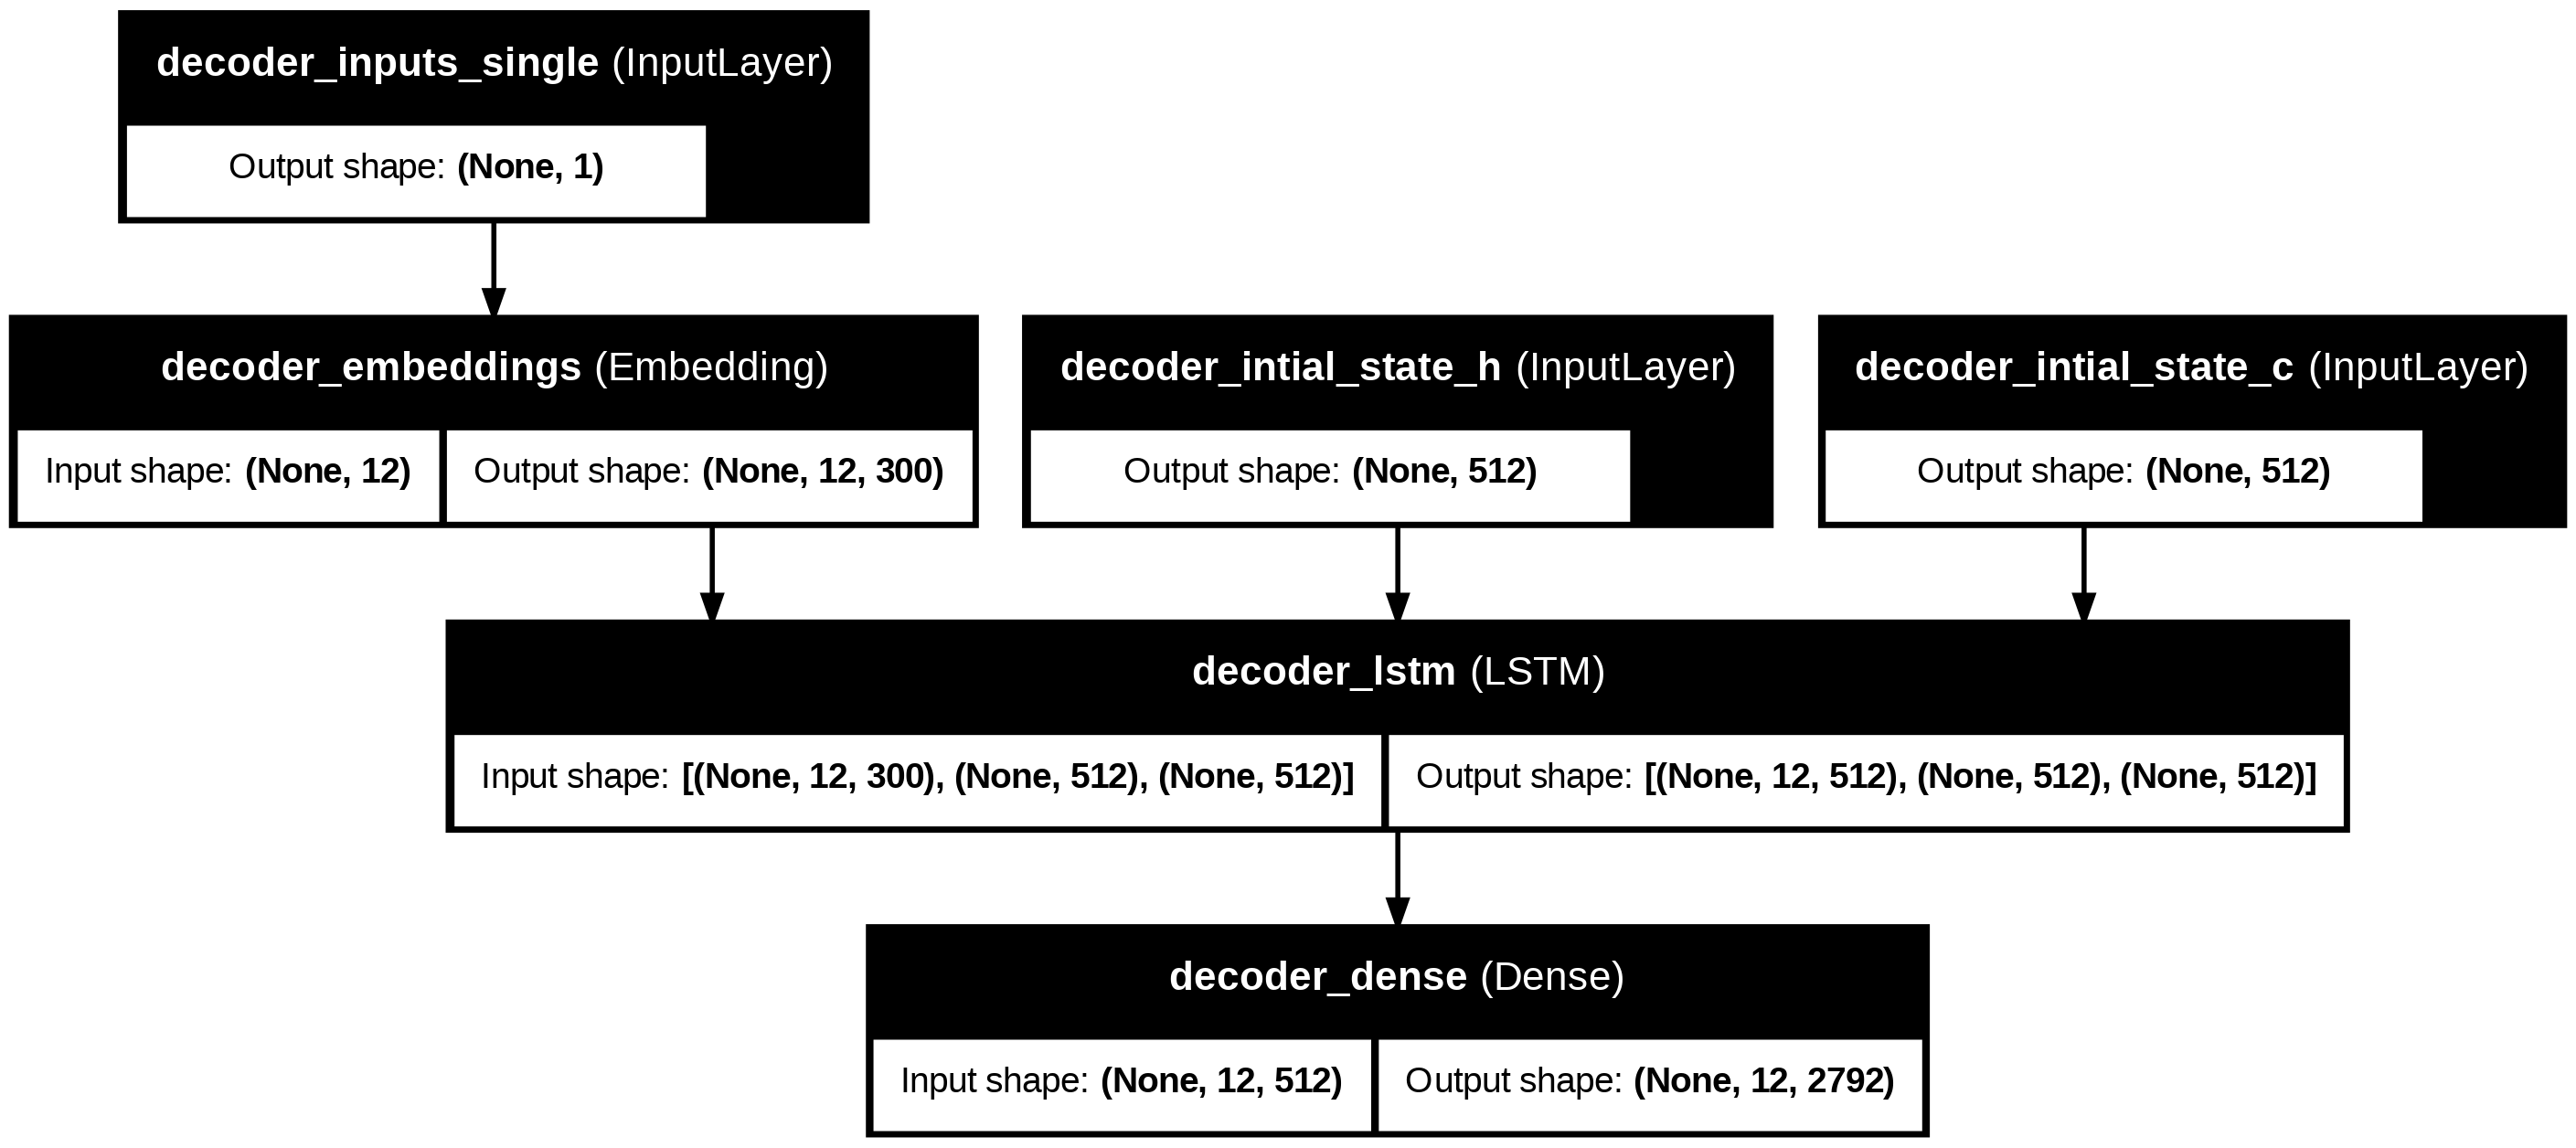

In [ ]:
from keras.callbacks import EarlyStopping, LearningRateScheduler

# Define LearningRateScheduler callback
def lr_schedule(epoch, lr):
    if lr < 3e-4:
      return lr

    if (epoch + 1) % 10 == 0:
      return lr / 3
    else:
      return lr

lr_scheduler = LearningRateScheduler(lr_schedule)


# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation acc
    patience=5,          # Stop after 3 epochs of no improvement
    restore_best_weights=True,
    verbose=1
)

# Fit the model with EarlyStopping
hist = model.fit(
    [in_encoder_pad, in_decoder_pad],
    out_decoder_ohot,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

    Epoch 1/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.5949 - loss: 2.7816 - val_accuracy: 0.6915 - val_loss: 1.8379 - learning_rate: 0.0010
    Epoch 2/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.7071 - loss: 1.6341 - val_accuracy: 0.6998 - val_loss: 1.7338 - learning_rate: 0.0010
    Epoch 3/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.7161 - loss: 1.4983 - val_accuracy: 0.7092 - val_loss: 1.6905 - learning_rate: 0.0010
    Epoch 4/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.7243 - loss: 1.3988 - val_accuracy: 0.7110 - val_loss: 1.6736 - learning_rate: 0.0010
    Epoch 5/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.7334 - loss: 1.3128 - val_accuracy: 0.7165 - val_loss: 1.6571 - learning_rate: 0.0010
    Epoch 6/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.7438 - loss: 1.2422 - val_accuracy: 0.7200 - val_loss: 1.6542 - learning_rate: 0.0010
    Epoch 7/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.7455 - loss: 1.1889 - val_accuracy: 0.7219 - val_loss: 1.6567 - learning_rate: 0.0010
    Epoch 8/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.7483 - loss: 1.1420 - val_accuracy: 0.7218 - val_loss: 1.6639 - learning_rate: 0.0010
    Epoch 9/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - accuracy: 0.7514 - loss: 1.0978 - val_accuracy: 0.7188 - val_loss: 1.6732 - learning_rate: 0.0010
    Epoch 10/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.7601 - loss: 1.0315 - val_accuracy: 0.7208 - val_loss: 1.6721 - learning_rate: 3.3333e-04
    Epoch 11/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.7607 - loss: 1.0120 - val_accuracy: 0.7219 - val_loss: 1.6771 - learning_rate: 3.3333e-04
    Epoch 12/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - accuracy: 0.7700 - loss: 0.9676 - val_accuracy: 0.7230 - val_loss: 1.6826 - learning_rate: 3.3333e-04
    Epoch 13/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.7682 - loss: 0.9615 - val_accuracy: 0.7226 - val_loss: 1.6892 - learning_rate: 3.3333e-04
    Epoch 14/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.7709 - loss: 0.9477 - val_accuracy: 0.7218 - val_loss: 1.6946 - learning_rate: 3.3333e-04
    Epoch 15/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.7754 - loss: 0.9265 - val_accuracy: 0.7216 - val_loss: 1.6992 - learning_rate: 3.3333e-04
    Epoch 16/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.7783 - loss: 0.9094 - val_accuracy: 0.7223 - val_loss: 1.7064 - learning_rate: 3.3333e-04
    Epoch 17/50
    216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.7824 - loss: 0.8843 - val_accuracy: 0.7212 - val_loss: 1.7115 - learning_rate: 3.3333e-04
    Epoch 17: early stopping
    Restoring model weights from the end of the best epoch: 12.

Obtuvimos una validation accuracy de 0.7230 lo cual implica una mejora considerable respecto al primer modelo entrenado.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

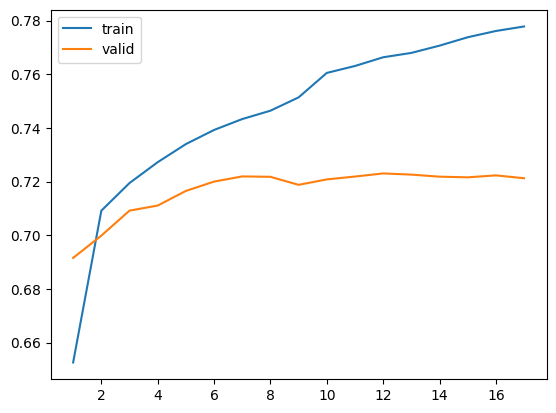

In [95]:
encoder_model.save('encoder_256_bidirectional.keras')
decoder_model.save('decoder_256_bidirectional.keras')

---

Nuevamente testeamos el modelo en las frases de testeo presentadas anteriormente.

In [ ]:
# Load the model
encoder_model = load_model('encoder_128_bidirectional.keras')
decoder_model = load_model('decoder_128_bidirectional.keras')

In [ ]:
np.random.seed(42)

i = np.random.choice(len(in_encoder_txt))
response = give_response(in_encoder_txt[i], tok, max_input_len)

print('\n')
print('Input:', in_encoder_txt[i])
print('Response:', response)

    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


    Input: i live in new york city i love it here
    Response: i love to read books

In [ ]:
input_txt = "Do you read?"
response = give_response(input_txt, tok, max_input_len)

print('\n')
print('Input:', input_txt)
print('Response:', response)

    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


    Input: Do you read?
    Response: i do not have a lot of time for that

In [ ]:
input_txt = "Do you have any pet?"
response = give_response(input_txt, tok, max_input_len)

print('\n')
print('Input:', input_txt)
print('Response:', response)

    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


    Input: Do you have any pet?
    Response: no

In [ ]:
input_txt = "Where are you from?"
response = give_response(input_txt, tok, max_input_len)

print('\n')
print('Input:', input_txt)
print('Response:', response)

    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


    Input: Where are you from?
    Response: i am from the united states

Podemos observar que todas las respuestas son coherentes con el primer mensaje enviado. El modelo provee resultados decentes considerando la simpleza de la arquitectura, y la escasez de datos para el entrenamiento.

---